# Regresor para estimar el espaciamiento espectral

- [x] Agregar la métrica de RMSE.
- [x] Cambiar las gráficas para que se distingan por marcadores y solo con los puntos discretos.
- [x] Probar con los datos GKM.
- [x] Cambiar ReLu por Swish.
- [x] Graficar la función de pérdida.
- [x] Variar el número de capas ocultas (1 a 4 capas, (relu), (relu, sigmoid), (relu, tanh, sigmoid), (relu, relu, tanh, sigmoid).
- [x] Hacer una prueba con la función de pérdida MSE, (RMSE).
- [x] Recortar el historial de peŕdida (Apróximadamente en 500, para ver el cambio brusco)
- [x] $\mu$ (eje y) vs. hidden layers number (eje x), para todos los escenarios (B2B, 0dBm, 9dBm), 3 gráficas (una para cada métrica) 
- [x] Para la evaluación de la función de pérdida (MSE vs. MAE) cambiar el eje y para usar $\mu$ y el eje x, se separan los escenarios (poner 3 índices y luego cambiarles la apariencia).
- [x] Solamente marcadores en negro para diferenciar.

In [1]:
# Imports
import sofa
import polars as pl
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import matplotlib.patheffects as pe
import tensorflow.keras as ker

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import cross_validate, KFold, train_test_split
from sklearn.preprocessing import StandardScaler

from tensorflow.keras import models, regularizers, Sequential, utils
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor

from time import time

2023-06-10 16:32:56.900430: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-06-10 16:32:56.905157: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-06-10 16:32:57.004769: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-06-10 16:32:57.007659: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-10 16:32:58.602878: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Co

## Funciones globales

In [2]:
def calc_once(varname, fn, args):
    """ Calculate a variable only once. """
    if varname not in globals():
        return fn(**args)
    return eval(varname)

### Regresión

In [3]:
def estimation_model(input_dim, layers_props_lst, loss_fn):
    """ Compile a sequential model for regression purposes. """
    model = ker.Sequential()
    # Hidden layers
    for i, layer_props in enumerate(layers_props_lst):
        if i == 0:
            model.add(ker.layers.Dense(**layer_props, input_dim=input_dim))
        else:
            model.add(ker.layers.Dense(**layer_props))
    # Regressor
    model.add(ker.layers.Dense(units=1, activation="linear"))
    
    model.compile(loss=loss_fn, optimizer="adam")
    return model


def estimation_crossvalidation(X, y, n_splits, layer_props, loss_fn, callbacks):
    """ Crossvalidation of an estimation network. """
    # Store initial time
    t0 = time()

    # Scores dict
    scores = {}
    scores["loss"] = []
    scores["mae"] = {"train": [], "test": []}
    scores["r2"] = {"train": [], "test": []}
    scores["rmse"] = {"train": [], "test": []}
    
    # K-fold crossvalidation
    kf = KFold(n_splits=n_splits, shuffle=True)

    for train_index, test_index in kf.split(X, y):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        # Input variables standarizer
        sc = StandardScaler()
        X_train = sc.fit_transform(X_train)
        X_test_kf = sc.transform(X_test)

        model = estimation_model(X_train.shape[1], layer_props, loss_fn)
        
        # Save test scalar loss
        if callbacks:
            loss = model.fit(
                X_train, y_train, epochs=5000, batch_size=64, verbose=0, callbacks=callbacks
            )
        else:
            loss = model.fit(X_train, y_train, epochs=5000, batch_size=64, verbose=0)
        print(f"Needed iterations: {len(loss.history['loss'])}")
        
        # Predict using train values
        predictions_train = model.predict(X_train)
        # Predict using test values
        predictions_test = model.predict(X_test_kf)

        # Dataframe for better visualization
        train_data_train = pl.DataFrame(
            {"ICI": [y_train], "Predicted ICI": [predictions_train]}
        )
        train_data_test = pl.DataFrame(
            {"ICI": [y_test], "Predicted ICI": [predictions_test]}
        )

        # MAE
        mae_score_train = mean_absolute_error(
            *train_data_train["ICI"], *train_data_train["Predicted ICI"]
        )
        mae_score_test = mean_absolute_error(
            *train_data_test["ICI"], *train_data_test["Predicted ICI"]
        )

        # R²
        r2_score_train = r2_score(
            *train_data_train["ICI"], *train_data_train["Predicted ICI"]
        )
        r2_score_test = r2_score(
            *train_data_test["ICI"], *train_data_test["Predicted ICI"]
        )
         
        # RMSE
        rmse_score_train = mean_squared_error(
            *train_data_train["ICI"], *train_data_train["Predicted ICI"],
            squared=False
        )
        rmse_score_test = mean_squared_error(
            *train_data_test["ICI"], *train_data_test["Predicted ICI"],
            squared=False
        )

        # Append to lists
        scores["loss"].append(loss)
        scores["mae"]["train"].append(mae_score_train)
        scores["mae"]["test"].append(mae_score_test)
        scores["r2"]["train"].append(r2_score_train)
        scores["r2"]["test"].append(r2_score_test)
        scores["rmse"]["train"].append(rmse_score_train)
        scores["rmse"]["test"].append(rmse_score_test)
        
    print(f"Time elapsed: {(time() - t0)/60:.2f} minutes")

    return scores


def test_estimation_model(data, n_splits, max_neurons, activations, 
                          use_osnr=True, loss_fn="mean_absolute_error"):
    """ Test a spectral spacing estimation model with given parameters. """
    var_n = 17 if use_osnr else 16

    # Split variables
    # Variables
    X = np.array(data[:, 0:var_n]).T
    # Tags
    y = np.array(data[:, 19:20]).T
    
    # Layer properties
    layer_props = [
        {"units": max_neurons // (2**i), "activation": activation}
        for i, activation in enumerate(activations)
    ]
    print(layer_props)
    callbacks = [
        EarlyStopping(monitor="loss", patience=30, mode="min", restore_best_weights=True)
    ]
    
    return estimation_crossvalidation(X, y, n_splits, layer_props, loss_fn, callbacks)


def plot_loss(score, end=500):
    """ Plot loss evolution for each k-fold. """
    for k, loss in enumerate(score["loss"]):
        loss_length = len(loss.history["loss"])
        loss_values = loss.history["loss"][:end if loss_length > end else loss_length]
        epoch_values = range(end if loss_length > end else loss_length)
        plt.plot(epoch_values, loss_values, label=f"k = {k+1}")

def plot_losses(scores, scenario, cmp_fn, cmp_values=[], end=500, based_on_index=False):
    """ Plot loss graphics for each scenario. """
    # Handle default cmp_values
    if len(cmp_values) == 0:
        cmp_values = np.zeros(len(scores))
        
    fig_loss = plt.figure(figsize=(16, 3*len(scores)), layout="constrained")
    fig_loss.suptitle(f"{scenario} loss history", size="x-large")
    
    for index, (score, cmps) in enumerate(zip(scores, cmp_values)):
        plt.subplot(len(scores)//2, 2, index + 1)
        plot_loss(score, end=end)
        
        plt.title(cmp_fn(cmps) if not based_on_index else cmp_fn(index))
        
        plt.xlabel("Iteration")
        plt.ylabel("Loss")
        
        # Transparent white box black edge legend
        legend = plt.legend(loc="upper right", edgecolor="black")
        legend.get_frame().set_alpha(None)
        legend.get_frame().set_facecolor((1, 1, 1, 0.01))
        
        plt.grid(True)

def plot_scores(scores, x_values, scenario, score_names, data_type,
                label, xlabel, markers=[], colors=[], based_on_index=False,
                log=False, multiple_points=False, plot_train=True):
    fig_scores = plt.figure(figsize=(16, 6), layout="constrained")
    fig_scores.suptitle(f"{scenario} scores")
    i = 0
    for sn in score_names:
        ax = plt.subplot(1, len(score_names), i+1)
        for dt in data_type:
            if not plot_train and dt == "train":
                continue
            points = [np.average(score[sn][dt]) for score in scores]
            if not multiple_points:
                label_value = ""
                plt.scatter(x_values, points, marker=markers[0 if dt == "train" else 1],
                            label=f"{dt.title()} {label(i)}", s=100)
            else:
                label_value = ""
                points1 = points[::2]
                points2 = points[1::2]
                plt.scatter(x_values, points1, marker=markers[0 if dt == "train" else 1],
                            color=colors[0 if dt == "train" else 1],
                            label=f"{dt.title()} {label(0)}", s=100)
                plt.scatter(x_values, points2, marker=markers[2 if dt == "train" else 3],
                            color=colors[2 if dt == "train" else 3],
                            label=f"{dt.title()} {label(1)}", s=100)
            title = ""
            if sn == "r2":
                title = "R²"
            elif sn == "acc":
                title = "Accuracy"
            else:
                title = sn.upper()
            plt.title(title)
                
        plt.xlabel(xlabel)
        # Adjust logarithmic scale if requested
        if log:
            plt.xscale("log", base=2)
            
        # Make integer xticks if matches}
        if type(x_values[0]) == np.int64:
            ax.set_xticks(x_values)
            
        if type(x_values[0]) == str:
            ax.set_xticks(range(len(x_values)), x_values)
            
        # Shrink current axis by 20%
        box = ax.get_position()
        ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

        # Transparent white box black edge legend
        legend = plt.legend(loc="center left", bbox_to_anchor=(1, 0.5),
                            edgecolor="black")
        legend.get_frame().set_alpha(None)
        legend.get_frame().set_facecolor((1, 1, 1, 0.01))

        plt.grid(True)
        i += 1
    plt.show()    
        
def plot_neurons_scores(scores, max_neurons, scenario):
    score_names = ["mae", "r2", "rmse"]
    data_type = ["train", "test"] 
    markers = ["o", "v"]
    
    # Plot loss
    plot_losses(scores, scenario, lambda neurons: f"{neurons} max number of neurons",
                max_neurons, end=500)
    plt.show()
    
    # Plot scores
    plot_scores(scores, max_neurons, scenario, score_names,
                data_type, label=lambda _: "",
                xlabel="Maximum number of neurons", 
                markers=markers, log=True)
    plt.show()

    
def plot_activations_scores(scores, scenario):
    pass
    # score_names = ["mae", "r2", "rmse"]
    # markers = ["^", "8", "*", "X"]
    # data_type = ["train", "test"]
    
    # # Graficar pérdida
    # plot_losses(scores, scenario,
    #             lambda index: f"{'FCM' if index%2 == 0 else 'GKM'} {'ReLu' if index<2 else 'Swish'}",
    #             end=500, based_on_index=True)
    # plt.show()
    
    # # Graficar puntajes
    # fig_scores = plt.figure(figsize=(16, 6), layout="constrained")
    # fig_scores.suptitle(f"{scenario} scores")
    # i = 0
    # for sn in score_names:
    #     plt.subplot(1, len(score_names), i+1)
    #     for dt in data_type:
    #         for j, (score, neurons) in enumerate(zip(scores, max_neurons)):
    #             points = score[sn][dt]

    #             k = np.arange(len(points), dtype = np.uint8) + 1
                 
    #             plt.scatter(k, points, marker=markers[j], 
    #                         label=f"{'FCM' if j%2 == 0 else 'GKM'} {'ReLu' if j<2 else 'Swish'}, µ = {np.mean(points):.3f}",
    #                         s = 100)
                
    #         plt.title(f"{'Train' if dt == 'train' else 'Test'}")
    #         plt.xlabel("k-fold")
    #         plt.xticks(k)
    #         plt.ylabel("MAE" if sn == "mae" else "R²" if sn == "r2" else "RMSE")
    #         ylim = plt.ylim()
    #         plt.ylim(ylim[0], (ylim[1] + (ylim[1] - ylim[0])*0.25))
    #         plt.grid(True)
    #         plt.legend(loc="upper right")
    #         i += 1
    # plt.show()
    
    
def plot_layers_scores(scores, scenario):
    score_names = ["mae", "r2", "rmse"]
    data_type = ["train", "test"]
    markers = ["D", "H"]
    
    # Plot loss
    plot_losses(scores, scenario, lambda hl_n: f"{hl_n} hidden layers", range(1, len(scores) + 1))
    plt.show()
    
    # Plot scores
    plot_scores(scores, np.arange(1, len(scores) + 1, 1, dtype=int),
                scenario, score_names, data_type, label=lambda _: "",
                xlabel="Number of hidden layers", markers=markers)
    plt.show()    
    
def plot_loss_scores(scores, scenario):
    score_names = ["mae", "r2", "rmse"]
    data_type = ["train", "test"]
    markers = ["o", "o", "D", "D"]
    colors = ["gold", "green", "gold", "green"]
    
    # Plot loss
    plot_losses(scores, scenario, 
                lambda index: f"{'MAE' if index%2==0 else 'MSE'} {'B2B' if index<2 else 'optical fiber at ' + ('0' if index<4 else '9') + ' dBm'}",
                based_on_index=True)
            
    # Plot scores
    plot_scores(scores, ["B2B", "0 dBm", "9 dBm"], scenario, score_names,
                data_type, label=lambda index: f"{'MAE' if index%2==0 else 'MSE'}",
                xlabel="Scenario", markers=markers, colors=colors, multiple_points=True,
                based_on_index=True)
    plt.show()    

## Restaurar variables

### Comparación variando el número máximo de neuronas por capa

#### FCM

In [ ]:
%store -r scores_FCM_1024_B2B
%store -r scores_FCM_512_B2B 
%store -r scores_FCM_256_B2B
%store -r scores_FCM_128_B2B

%store -r scores_FCM_1024_fiber0
%store -r scores_FCM_512_fiber0
%store -r scores_FCM_256_fiber0
%store -r scores_FCM_128_fiber0

%store -r scores_FCM_1024_fiber9
%store -r scores_FCM_512_fiber9
%store -r scores_FCM_256_fiber9
%store -r scores_FCM_128_fiber9

%store -r scores_FCM_1024_woOSNR_B2B
%store -r scores_FCM_512_woOSNR_B2B 
%store -r scores_FCM_256_woOSNR_B2B
%store -r scores_FCM_128_woOSNR_B2B

%store -r scores_FCM_1024_woOSNR_fiber0
%store -r scores_FCM_512_woOSNR_fiber0
%store -r scores_FCM_256_woOSNR_fiber0
%store -r scores_FCM_128_woOSNR_fiber0

%store -r scores_FCM_1024_woOSNR_fiber9
%store -r scores_FCM_512_woOSNR_fiber9
%store -r scores_FCM_256_woOSNR_fiber9
%store -r scores_FCM_128_woOSNR_fiber9

#### GKM

In [5]:
%store -r scores_GKM_1024_B2B
%store -r scores_GKM_512_B2B 
%store -r scores_GKM_256_B2B
%store -r scores_GKM_128_B2B

%store -r scores_GKM_1024_fiber0
%store -r scores_GKM_512_fiber0
%store -r scores_GKM_256_fiber0
%store -r scores_GKM_128_fiber0

%store -r scores_GKM_1024_fiber9
%store -r scores_GKM_512_fiber9
%store -r scores_GKM_256_fiber9
%store -r scores_GKM_128_fiber9

%store -r scores_GKM_1024_woOSNR_B2B
%store -r scores_GKM_512_woOSNR_B2B 
%store -r scores_GKM_256_woOSNR_B2B
%store -r scores_GKM_128_woOSNR_B2B

%store -r scores_GKM_1024_woOSNR_fiber0
%store -r scores_GKM_512_woOSNR_fiber0
%store -r scores_GKM_256_woOSNR_fiber0
%store -r scores_GKM_128_woOSNR_fiber0

%store -r scores_GKM_1024_woOSNR_fiber9
%store -r scores_GKM_512_woOSNR_fiber9
%store -r scores_GKM_256_woOSNR_fiber9
%store -r scores_GKM_128_woOSNR_fiber9

### Comparación variando la primera función de activación (ReLu vs. Swish)

In [6]:
# %store -r scores_FCM_relu_B2B
# %store -r scores_GKM_relu_B2B
# %store -r scores_FCM_swish_B2B
# %store -r scores_GKM_swish_B2B
# 
# %store -r scores_FCM_relu_fiber0
# %store -r scores_GKM_relu_fiber0
# %store -r scores_FCM_swish_fiber0
# %store -r scores_GKM_swish_fiber0
# 
# %store -r scores_FCM_relu_fiber9
# %store -r scores_GKM_relu_fiber9
# %store -r scores_FCM_swish_fiber9
# %store -r scores_GKM_swish_fiber9

### Comparación variando el número de capas ocultas

In [15]:
%store -r scores_FCM_B2B_1HL
%store -r scores_FCM_B2B_2HL
%store -r scores_FCM_B2B_3HL
%store -r scores_FCM_B2B_4HL

%store -r scores_FCM_fiber0_1HL
%store -r scores_FCM_fiber0_2HL
%store -r scores_FCM_fiber0_3HL
%store -r scores_FCM_fiber0_4HL

%store -r scores_FCM_fiber9_1HL
%store -r scores_FCM_fiber9_2HL
%store -r scores_FCM_fiber9_3HL
%store -r scores_FCM_fiber9_4HL

%store -r scores_FCM_B2B_1HL_woOSNR
%store -r scores_FCM_B2B_2HL_woOSNR
%store -r scores_FCM_B2B_3HL_woOSNR
%store -r scores_FCM_B2B_4HL_woOSNR

%store -r scores_FCM_fiber0_1HL_woOSNR
%store -r scores_FCM_fiber0_2HL_woOSNR
%store -r scores_FCM_fiber0_3HL_woOSNR
%store -r scores_FCM_fiber0_4HL_woOSNR

%store -r scores_FCM_fiber9_1HL_woOSNR
%store -r scores_FCM_fiber9_2HL_woOSNR
%store -r scores_FCM_fiber9_3HL_woOSNR
%store -r scores_FCM_fiber9_4HL_woOSNR

%store -r scores_GKM_B2B_1HL
%store -r scores_GKM_B2B_2HL
%store -r scores_GKM_B2B_3HL
%store -r scores_GKM_B2B_4HL

%store -r scores_GKM_fiber0_1HL
%store -r scores_GKM_fiber0_2HL
%store -r scores_GKM_fiber0_3HL
%store -r scores_GKM_fiber0_4HL

%store -r scores_GKM_fiber9_1HL
%store -r scores_GKM_fiber9_2HL
%store -r scores_GKM_fiber9_3HL
%store -r scores_GKM_fiber9_4HL

%store -r scores_GKM_B2B_1HL_woOSNR
%store -r scores_GKM_B2B_2HL_woOSNR
%store -r scores_GKM_B2B_3HL_woOSNR
%store -r scores_GKM_B2B_4HL_woOSNR

%store -r scores_GKM_fiber0_1HL_woOSNR
%store -r scores_GKM_fiber0_2HL_woOSNR
%store -r scores_GKM_fiber0_3HL_woOSNR
%store -r scores_GKM_fiber0_4HL_woOSNR

%store -r scores_GKM_fiber9_1HL_woOSNR
%store -r scores_GKM_fiber9_2HL_woOSNR
%store -r scores_GKM_fiber9_3HL_woOSNR
%store -r scores_GKM_fiber9_4HL_woOSNR

### Comparación variando la función de pérdida (MAE vs. RMSE)

In [6]:
# %store -r scores_FCM_MAE_B2B
# %store -r scores_FCM_MSE_B2B
# 
# %store -r scores_FCM_MAE_fiber0
# %store -r scores_FCM_MSE_fiber0
# 
# %store -r scores_FCM_MAE_fiber9
# %store -r scores_FCM_MSE_fiber9

## Cargar los datos

### FCM

In [6]:
data_file_FCM = "../Databases/CaractFCM.csv"
df_FCM = pl.read_csv(data_file_FCM, dtypes=[pl.Float64], has_header=False)

# Scenarios split
# Back-to-back (B2B)
df_FCM_B2B = df_FCM[0:987, :]
# 0dBm optical fiber
df_FCM_fiber0 = df_FCM[988:1520, :]
# 9dBm optical fiber
df_FCM_fiber9 = df_FCM[1521:, :]

### GKM

In [7]:
data_file_GKM = "../Databases/CaractGKM.csv"
df_GKM = pl.read_csv(data_file_GKM, dtypes=[pl.Float64], infer_schema_length = 10000, has_header=False)

# Scenarios split
# Back-to-back (B2B)
df_GKM_B2B = df_GKM[0:987, :]

# 0dBm optical fiber
df_GKM_fiber0 = df_GKM[988:1520, :]

# 9dBm optical fiber
df_GKM_fiber9 = df_GKM[1521:, :]

## Comparación variando el número máximo de neuronas por capa (con OSNR)

### FCM B2B

In [6]:
args = {"data": df_FCM_B2B, "n_splits": 5, "max_neurons": 1024, "activations": ["relu", "tanh", "sigmoid"]}
scores_FCM_1024_B2B = calc_once("scores_FCM_1024_B2B", test_estimation_model, args)

[{'units': 1024, 'activation': 'relu'}, {'units': 512, 'activation': 'tanh'}, {'units': 256, 'activation': 'sigmoid'}]
Needed iterations: 334
7/7 [==============================] - 0s 1ms/step
Needed iterations: 229
7/7 [==============================] - 0s 1ms/step
Needed iterations: 435
7/7 [==============================] - 0s 1ms/step
Needed iterations: 494
7/7 [==============================] - 0s 2ms/step
Needed iterations: 433
7/7 [==============================] - 0s 1ms/step
Time elapsed: 2.13 minutes


In [7]:
args = {"data": df_FCM_B2B, "n_splits": 5, "max_neurons": 512, "activations": ["relu", "tanh", "sigmoid"]}
scores_FCM_512_B2B = calc_once("scores_FCM_512_B2B", test_estimation_model, args)

[{'units': 512, 'activation': 'relu'}, {'units': 256, 'activation': 'tanh'}, {'units': 128, 'activation': 'sigmoid'}]
Needed iterations: 657
7/7 [==============================] - 0s 886us/step
Needed iterations: 404
7/7 [==============================] - 0s 964us/step
Needed iterations: 558
7/7 [==============================] - 0s 1ms/step
Needed iterations: 394
7/7 [==============================] - 0s 1ms/step
Needed iterations: 402
7/7 [==============================] - 0s 1ms/step
Time elapsed: 1.04 minutes


In [8]:
args = {"data": df_FCM_B2B, "n_splits": 5, "max_neurons": 256, "activations": ["relu", "tanh", "sigmoid"]}
scores_FCM_256_B2B = calc_once("scores_FCM_256_B2B", test_estimation_model, args)

[{'units': 256, 'activation': 'relu'}, {'units': 128, 'activation': 'tanh'}, {'units': 64, 'activation': 'sigmoid'}]
Needed iterations: 657
7/7 [==============================] - 0s 945us/step
Needed iterations: 584
7/7 [==============================] - 0s 2ms/step
Needed iterations: 715
7/7 [==============================] - 0s 819us/step
Needed iterations: 647
7/7 [==============================] - 0s 759us/step
Needed iterations: 743
7/7 [==============================] - 0s 831us/step
Time elapsed: 0.75 minutes


In [9]:
args = {"data": df_FCM_B2B, "n_splits": 5, "max_neurons": 128, "activations": ["relu", "tanh", "sigmoid"]}
scores_FCM_128_B2B = calc_once("scores_FCM_128_B2B", test_estimation_model, args)

[{'units': 128, 'activation': 'relu'}, {'units': 64, 'activation': 'tanh'}, {'units': 32, 'activation': 'sigmoid'}]
Needed iterations: 1053
7/7 [==============================] - 0s 859us/step
Needed iterations: 628
7/7 [==============================] - 0s 772us/step
Needed iterations: 859
7/7 [==============================] - 0s 767us/step
Needed iterations: 671
7/7 [==============================] - 0s 889us/step
Needed iterations: 766
7/7 [==============================] - 0s 805us/step
Time elapsed: 0.67 minutes


In [10]:
%store scores_FCM_1024_B2B
%store scores_FCM_512_B2B 
%store scores_FCM_256_B2B
%store scores_FCM_128_B2B

Stored 'scores_FCM_1024_B2B' (dict)
Stored 'scores_FCM_512_B2B' (dict)
Stored 'scores_FCM_256_B2B' (dict)
Stored 'scores_FCM_128_B2B' (dict)


#### Gráficas

In [11]:
#scores = [scores_FCM_1024_B2B, scores_FCM_512_B2B, scores_FCM_256_B2B, scores_FCM_128_B2B]
#max_neurons = [1024, 512, 256, 128]
#plot_neurons_scores(scores, max_neurons, "FCM B2B")

### FCM con fibra óptica a 0dBm

In [12]:
args = {"data": df_FCM_fiber0, "n_splits": 5, "max_neurons": 1024, "activations": ["relu", "tanh", "sigmoid"]}
scores_FCM_1024_fiber0 = calc_once("scores_FCM_1024_fiber0", test_estimation_model, args)

[{'units': 1024, 'activation': 'relu'}, {'units': 512, 'activation': 'tanh'}, {'units': 256, 'activation': 'sigmoid'}]
Needed iterations: 54
4/4 [==============================] - 0s 2ms/step
Needed iterations: 681
4/4 [==============================] - 0s 2ms/step
Needed iterations: 67
4/4 [==============================] - 0s 1ms/step
Needed iterations: 55
4/4 [==============================] - 0s 2ms/step
Needed iterations: 460
4/4 [==============================] - 0s 1ms/step
Time elapsed: 0.80 minutes


In [13]:
args = {"data": df_FCM_fiber0, "n_splits": 5, "max_neurons": 512, "activations": ["relu", "tanh", "sigmoid"]}
scores_FCM_512_fiber0 = calc_once("scores_FCM_512_fiber0", test_estimation_model, args)

[{'units': 512, 'activation': 'relu'}, {'units': 256, 'activation': 'tanh'}, {'units': 128, 'activation': 'sigmoid'}]
Needed iterations: 512
4/4 [==============================] - 0s 1ms/step
Needed iterations: 550
4/4 [==============================] - 0s 1ms/step
Needed iterations: 526
4/4 [==============================] - 0s 1ms/step
Needed iterations: 565
4/4 [==============================] - 0s 1ms/step
Needed iterations: 472
4/4 [==============================] - 0s 2ms/step
Time elapsed: 0.59 minutes


In [14]:
args = {"data": df_FCM_fiber0, "n_splits": 5, "max_neurons": 256, "activations": ["relu", "tanh", "sigmoid"]}
scores_FCM_256_fiber0 = calc_once("scores_FCM_256_fiber0", test_estimation_model, args)

[{'units': 256, 'activation': 'relu'}, {'units': 128, 'activation': 'tanh'}, {'units': 64, 'activation': 'sigmoid'}]
Needed iterations: 1006
4/4 [==============================] - 0s 980us/step
Needed iterations: 838
4/4 [==============================] - 0s 1ms/step
Needed iterations: 633
4/4 [==============================] - 0s 886us/step
Needed iterations: 689
4/4 [==============================] - 0s 991us/step
Needed iterations: 775
4/4 [==============================] - 0s 911us/step
Time elapsed: 0.50 minutes


In [15]:
args = {"data": df_FCM_fiber0, "n_splits": 5, "max_neurons": 128, "activations": ["relu", "tanh", "sigmoid"]}
scores_FCM_128_fiber0 = calc_once("scores_FCM_128_fiber0", test_estimation_model, args)

[{'units': 128, 'activation': 'relu'}, {'units': 64, 'activation': 'tanh'}, {'units': 32, 'activation': 'sigmoid'}]
Needed iterations: 395
4/4 [==============================] - 0s 1ms/step
Needed iterations: 1249
4/4 [==============================] - 0s 827us/step
Needed iterations: 409
4/4 [==============================] - 0s 875us/step
Needed iterations: 859
4/4 [==============================] - 0s 884us/step
Needed iterations: 338
4/4 [==============================] - 0s 872us/step
Time elapsed: 0.36 minutes


In [16]:
%store scores_FCM_1024_fiber0 
%store scores_FCM_512_fiber0 
%store scores_FCM_256_fiber0 
%store scores_FCM_128_fiber0

Stored 'scores_FCM_1024_fiber0' (dict)
Stored 'scores_FCM_512_fiber0' (dict)
Stored 'scores_FCM_256_fiber0' (dict)
Stored 'scores_FCM_128_fiber0' (dict)


#### Gráficas

In [17]:
#scores = [scores_FCM_1024_fiber0, scores_FCM_512_fiber0, scores_FCM_256_fiber0, scores_FCM_128_fiber0]
#max_neurons = [1024, 512, 256, 128]
#plot_neurons_scores(scores, max_neurons, scenario="FCM optical fiber at 0dBm")

### FCM con fibra óptica a 9dBm

In [18]:
args = {"data": df_FCM_fiber9, "n_splits": 5, "max_neurons": 1024, "activations": ["relu", "tanh", "sigmoid"]}
scores_FCM_1024_fiber9 = calc_once("scores_FCM_1024_fiber9", test_estimation_model, args)

[{'units': 1024, 'activation': 'relu'}, {'units': 512, 'activation': 'tanh'}, {'units': 256, 'activation': 'sigmoid'}]
Needed iterations: 56
6/6 [==============================] - 0s 1ms/step
Needed iterations: 51
6/6 [==============================] - 0s 1ms/step
Needed iterations: 229
6/6 [==============================] - 0s 1ms/step
Needed iterations: 55
6/6 [==============================] - 0s 1ms/step
Needed iterations: 182
6/6 [==============================] - 0s 2ms/step
Time elapsed: 0.61 minutes


In [19]:
args = {"data": df_FCM_fiber9, "n_splits": 5, "max_neurons": 512, "activations": ["relu", "tanh", "sigmoid"]}
scores_FCM_512_fiber9 = calc_once("scores_FCM_512_fiber9", test_estimation_model, args)

[{'units': 512, 'activation': 'relu'}, {'units': 256, 'activation': 'tanh'}, {'units': 128, 'activation': 'sigmoid'}]
Needed iterations: 264
6/6 [==============================] - 0s 2ms/step
Needed iterations: 277
6/6 [==============================] - 0s 1ms/step
Needed iterations: 289
6/6 [==============================] - 0s 1ms/step
Needed iterations: 300
6/6 [==============================] - 0s 1ms/step
Needed iterations: 265
6/6 [==============================] - 0s 876us/step
Time elapsed: 0.52 minutes


In [20]:
args = {"data": df_FCM_fiber9, "n_splits": 5, "max_neurons": 256, "activations": ["relu", "tanh", "sigmoid"]}
scores_FCM_256_fiber9 = calc_once("scores_FCM_256_fiber9", test_estimation_model, args)

[{'units': 256, 'activation': 'relu'}, {'units': 128, 'activation': 'tanh'}, {'units': 64, 'activation': 'sigmoid'}]
Needed iterations: 345
6/6 [==============================] - 0s 990us/step
Needed iterations: 372
6/6 [==============================] - 0s 748us/step
Needed iterations: 320
6/6 [==============================] - 0s 919us/step
Needed iterations: 426
6/6 [==============================] - 0s 1ms/step
Needed iterations: 375
6/6 [==============================] - 0s 807us/step
Time elapsed: 0.39 minutes


In [21]:
args = {"data": df_FCM_fiber9, "n_splits": 5, "max_neurons": 128, "activations": ["relu", "tanh", "sigmoid"]}
scores_FCM_128_fiber9 = calc_once("scores_FCM_128_fiber9", test_estimation_model, args)

[{'units': 128, 'activation': 'relu'}, {'units': 64, 'activation': 'tanh'}, {'units': 32, 'activation': 'sigmoid'}]
Needed iterations: 260
6/6 [==============================] - 0s 840us/step
Needed iterations: 479
6/6 [==============================] - 0s 794us/step
Needed iterations: 517
6/6 [==============================] - 0s 744us/step
Needed iterations: 184
6/6 [==============================] - 0s 794us/step
Needed iterations: 508
6/6 [==============================] - 0s 951us/step
Time elapsed: 0.35 minutes


In [22]:
%store scores_FCM_1024_fiber9
%store scores_FCM_512_fiber9 
%store scores_FCM_256_fiber9 
%store scores_FCM_128_fiber9

Stored 'scores_FCM_1024_fiber9' (dict)
Stored 'scores_FCM_512_fiber9' (dict)
Stored 'scores_FCM_256_fiber9' (dict)
Stored 'scores_FCM_128_fiber9' (dict)


#### Gráficas

In [23]:
#scores = [scores_FCM_1024_fiber9, scores_FCM_512_fiber9, scores_FCM_256_fiber9, scores_FCM_128_fiber9]
#max_neurons = [1024, 512, 256, 128]
#plot_neurons_scores(scores, max_neurons, "FCM optical fiber at 9dBm")

### GKM B2B

In [24]:
args = {"data": df_GKM_B2B, "n_splits": 5, "max_neurons": 1024, "activations": ["relu", "tanh", "sigmoid"]}
scores_GKM_1024_B2B = calc_once("scores_GKM_1024_B2B", test_estimation_model, args)

[{'units': 1024, 'activation': 'relu'}, {'units': 512, 'activation': 'tanh'}, {'units': 256, 'activation': 'sigmoid'}]
Needed iterations: 303
7/7 [==============================] - 0s 1ms/step
Needed iterations: 190
7/7 [==============================] - 0s 1ms/step
Needed iterations: 45
7/7 [==============================] - 0s 2ms/step
Needed iterations: 180
7/7 [==============================] - 0s 1ms/step
Needed iterations: 200
7/7 [==============================] - 0s 1ms/step
Time elapsed: 1.03 minutes


In [25]:
args = {"data": df_GKM_B2B, "n_splits": 5, "max_neurons": 512, "activations": ["relu", "tanh", "sigmoid"]}
scores_GKM_512_B2B = calc_once("scores_GKM_512_B2B", test_estimation_model, args)

[{'units': 512, 'activation': 'relu'}, {'units': 256, 'activation': 'tanh'}, {'units': 128, 'activation': 'sigmoid'}]
Needed iterations: 330
7/7 [==============================] - 0s 1ms/step
Needed iterations: 260
7/7 [==============================] - 0s 836us/step
Needed iterations: 289
7/7 [==============================] - 0s 1ms/step
Needed iterations: 326
7/7 [==============================] - 0s 994us/step
Needed iterations: 276
7/7 [==============================] - 0s 921us/step
Time elapsed: 0.60 minutes


In [26]:
args = {"data": df_GKM_B2B, "n_splits": 5, "max_neurons": 256, "activations": ["relu", "tanh", "sigmoid"]}
scores_GKM_256_B2B = calc_once("scores_GKM_256_B2B", test_estimation_model, args)

[{'units': 256, 'activation': 'relu'}, {'units': 128, 'activation': 'tanh'}, {'units': 64, 'activation': 'sigmoid'}]
Needed iterations: 641
7/7 [==============================] - 0s 926us/step
Needed iterations: 523
7/7 [==============================] - 0s 1ms/step
Needed iterations: 576
7/7 [==============================] - 0s 741us/step
Needed iterations: 713
7/7 [==============================] - 0s 933us/step
Needed iterations: 613
7/7 [==============================] - 0s 833us/step
Time elapsed: 0.64 minutes


In [ ]:
args = {"data": df_GKM_B2B, "n_splits": 5, "max_neurons": 128, "activations": ["relu", "tanh", "sigmoid"]}
scores_GKM_128_B2B = calc_once("scores_GKM_128_B2B", test_estimation_model, args)

[{'units': 128, 'activation': 'relu'}, {'units': 64, 'activation': 'tanh'}, {'units': 32, 'activation': 'sigmoid'}]
Needed iterations: 497
25/25 [==============================] - 0s 654us/step


In [ ]:
%store scores_GKM_1024_B2B
%store scores_GKM_512_B2B
%store scores_GKM_256_B2B
%store scores_GKM_128_B2B

#### Gráficas

In [ ]:
#scores = [scores_GKM_1024_B2B, scores_GKM_512_B2B, scores_GKM_256_B2B, scores_GKM_128_B2B]
#max_neurons = [1024, 512, 256, 128]
#plot_neurons_scores(scores, max_neurons, "GKM B2B")

### GKM con fibra óptica a 0dBm

In [ ]:
args = {"data": df_GKM_fiber0, "n_splits": 5, "max_neurons": 1024, "activations": ["relu", "tanh", "sigmoid"]}
scores_GKM_1024_fiber0 = calc_once("scores_GKM_1024_fiber0", test_estimation_model, args)

In [ ]:
args = {"data": df_GKM_fiber0, "n_splits": 5, "max_neurons": 512, "activations": ["relu", "tanh", "sigmoid"]}
scores_GKM_512_fiber0 = calc_once("scores_GKM_512_fiber0", test_estimation_model, args)

In [ ]:
args = {"data": df_GKM_fiber0, "n_splits": 5, "max_neurons": 256, "activations": ["relu", "tanh", "sigmoid"]}
scores_GKM_256_fiber0 = calc_once("scores_GKM_256_fiber0", test_estimation_model, args)

In [ ]:
args = {"data": df_GKM_fiber0, "n_splits": 5, "max_neurons": 128, "activations": ["relu", "tanh", "sigmoid"]}
scores_GKM_128_fiber0 = calc_once("scores_GKM_128_fiber0", test_estimation_model, args)

In [ ]:
%store scores_GKM_1024_fiber0
%store scores_GKM_512_fiber0
%store scores_GKM_256_fiber0
%store scores_GKM_128_fiber0

#### Gráficas

In [ ]:
#scores = [scores_GKM_1024_fiber0, scores_GKM_512_fiber0, scores_GKM_256_fiber0, scores_GKM_128_fiber0]
#max_neurons = [1024, 512, 256, 128]
#plot_neurons_scores(scores, max_neurons, "GKM optical fiber at 0dBm")

### GKM con fibra óptica a 9dBm

In [ ]:
args = {"data": df_GKM_fiber9, "n_splits": 5, "max_neurons": 1024, "activations": ["relu", "tanh", "sigmoid"]}
scores_GKM_1024_fiber9 = calc_once("scores_GKM_1024_fiber9", test_estimation_model, args)

In [ ]:
args = {"data": df_GKM_fiber9, "n_splits": 5, "max_neurons": 512, "activations": ["relu", "tanh", "sigmoid"]}
scores_GKM_512_fiber9 = calc_once("scores_GKM_512_fiber9", test_estimation_model, args)

In [ ]:
args = {"data": df_GKM_fiber9, "n_splits": 5, "max_neurons": 256, "activations": ["relu", "tanh", "sigmoid"]}
scores_GKM_256_fiber9 = calc_once("scores_GKM_256_fiber9", test_estimation_model, args)

In [ ]:
args = {"data": df_GKM_fiber9, "n_splits": 5, "max_neurons": 128, "activations": ["relu", "tanh", "sigmoid"]}
scores_GKM_128_fiber9 = calc_once("scores_GKM_128_fiber9", test_estimation_model, args)

In [ ]:
%store scores_GKM_1024_fiber9
%store scores_GKM_512_fiber9
%store scores_GKM_256_fiber9
%store scores_GKM_128_fiber9

## Comparación variando el número máximo de neuronas por capa (sin OSNR)

In [ ]:
args = {"data": df_FCM_B2B, "n_splits": 5, "max_neurons": 1024, "activations": ["relu", "tanh", "sigmoid"], "use_osnr": False}
scores_FCM_1024_woOSNR_B2B = calc_once("scores_FCM_1024_woOSNR_B2B", test_estimation_model, args)

In [ ]:
args = {"data": df_FCM_B2B, "n_splits": 5, "max_neurons": 512, "activations": ["relu", "tanh", "sigmoid"], "use_osnr": False}
scores_FCM_512_woOSNR_B2B = calc_once("scores_FCM_512_woOSNR_B2B", test_estimation_model, args)

In [ ]:
args = {"data": df_FCM_B2B, "n_splits": 5, "max_neurons": 256, "activations": ["relu", "tanh", "sigmoid"], "use_osnr": False}
scores_FCM_256_woOSNR_B2B = calc_once("scores_FCM_256_woOSNR_B2B", test_estimation_model, args)

In [ ]:
args = {"data": df_FCM_B2B, "n_splits": 5, "max_neurons": 128, "activations": ["relu", "tanh", "sigmoid"], "use_osnr": False}
scores_FCM_128_woOSNR_B2B = calc_once("scores_FCM_128_woOSNR_B2B", test_estimation_model, args)

In [ ]:
%store scores_FCM_1024_woOSNR_B2B
%store scores_FCM_512_woOSNR_B2B 
%store scores_FCM_256_woOSNR_B2B
%store scores_FCM_128_woOSNR_B2B

### FCM con fibra óptica a 0dBm

In [ ]:
args = {"data": df_FCM_fiber0, "n_splits": 5, "max_neurons": 1024, "activations": ["relu", "tanh", "sigmoid"], "use_osnr": False}
scores_FCM_1024_woOSNR_fiber0 = calc_once("scores_FCM_1024_woOSNR_fiber0", test_estimation_model, args)

In [ ]:
args = {"data": df_FCM_fiber0, "n_splits": 5, "max_neurons": 512, "activations": ["relu", "tanh", "sigmoid"], "use_osnr": False}
scores_FCM_512_woOSNR_fiber0 = calc_once("scores_FCM_512_woOSNR_fiber0", test_estimation_model, args)

In [ ]:
args = {"data": df_FCM_fiber0, "n_splits": 5, "max_neurons": 256, "activations": ["relu", "tanh", "sigmoid"], "use_osnr": False}
scores_FCM_256_woOSNR_fiber0 = calc_once("scores_FCM_256_woOSNR_fiber0", test_estimation_model, args)

In [ ]:
args = {"data": df_FCM_fiber0, "n_splits": 5, "max_neurons": 128, "activations": ["relu", "tanh", "sigmoid"], "use_osnr": False}
scores_FCM_128_woOSNR_fiber0 = calc_once("scores_FCM_128_woOSNR_fiber0", test_estimation_model, args)

In [ ]:
%store scores_FCM_1024_woOSNR_fiber0 
%store scores_FCM_512_woOSNR_fiber0 
%store scores_FCM_256_woOSNR_fiber0 
%store scores_FCM_128_woOSNR_fiber0

### FCM con fibra óptica a 9dBm

In [ ]:
args = {"data": df_FCM_fiber9, "n_splits": 5, "max_neurons": 1024, "activations": ["relu", "tanh", "sigmoid"], "use_osnr": False}
scores_FCM_1024_woOSNR_fiber9 = calc_once("scores_FCM_1024_woOSNR_fiber9", test_estimation_model, args)

In [ ]:
args = {"data": df_FCM_fiber9, "n_splits": 5, "max_neurons": 512, "activations": ["relu", "tanh", "sigmoid"], "use_osnr": False}
scores_FCM_512_woOSNR_fiber9 = calc_once("scores_FCM_512_woOSNR_fiber9", test_estimation_model, args)

In [ ]:
args = {"data": df_FCM_fiber9, "n_splits": 5, "max_neurons": 256, "activations": ["relu", "tanh", "sigmoid"], "use_osnr": False}
scores_FCM_256_woOSNR_fiber9 = calc_once("scores_FCM_256_woOSNR_fiber9", test_estimation_model, args)

In [ ]:
args = {"data": df_FCM_fiber9, "n_splits": 5, "max_neurons": 128, "activations": ["relu", "tanh", "sigmoid"], "use_osnr": False}
scores_FCM_128_woOSNR_fiber9 = calc_once("scores_FCM_128_woOSNR_fiber9", test_estimation_model, args)

In [ ]:
%store scores_FCM_1024_woOSNR_fiber9
%store scores_FCM_512_woOSNR_fiber9 
%store scores_FCM_256_woOSNR_fiber9 
%store scores_FCM_128_woOSNR_fiber9

### GKM B2B

In [ ]:
args = {"data": df_GKM_B2B, "n_splits": 5, "max_neurons": 1024, "activations": ["relu", "tanh", "sigmoid"], "use_osnr": False}
scores_GKM_1024_woOSNR_B2B = calc_once("scores_GKM_1024_woOSNR_B2B", test_estimation_model, args)

In [ ]:
args = {"data": df_GKM_B2B, "n_splits": 5, "max_neurons": 512, "activations": ["relu", "tanh", "sigmoid"], "use_osnr": False}
scores_GKM_512_woOSNR_B2B = calc_once("scores_GKM_512_woOSNR_B2B", test_estimation_model, args)

In [ ]:
args = {"data": df_GKM_B2B, "n_splits": 5, "max_neurons": 256, "activations": ["relu", "tanh", "sigmoid"], "use_osnr": False}
scores_GKM_256_woOSNR_B2B = calc_once("scores_GKM_256_woOSNR_B2B", test_estimation_model, args)

In [ ]:
args = {"data": df_GKM_B2B, "n_splits": 5, "max_neurons": 128, "activations": ["relu", "tanh", "sigmoid"], "use_osnr": False}
scores_GKM_128_woOSNR_B2B = calc_once("scores_GKM_128_woOSNR_B2B", test_estimation_model, args)

In [ ]:
%store scores_GKM_1024_woOSNR_B2B
%store scores_GKM_512_woOSNR_B2B
%store scores_GKM_256_woOSNR_B2B
%store scores_GKM_128_woOSNR_B2B

### GKM con fibra óptica a 0dBm

In [ ]:
args = {"data": df_GKM_fiber0, "n_splits": 5, "max_neurons": 1024, "activations": ["relu", "tanh", "sigmoid"], "use_osnr": False}
scores_GKM_1024_woOSNR_fiber0 = calc_once("scores_GKM_1024_woOSNR_fiber0", test_estimation_model, args)

In [ ]:
args = {"data": df_GKM_fiber0, "n_splits": 5, "max_neurons": 512, "activations": ["relu", "tanh", "sigmoid"], "use_osnr": False}
scores_GKM_512_woOSNR_fiber0 = calc_once("scores_GKM_512_woOSNR_fiber0", test_estimation_model, args)

In [ ]:
args = {"data": df_GKM_fiber0, "n_splits": 5, "max_neurons": 256, "activations": ["relu", "tanh", "sigmoid"], "use_osnr": False}
scores_GKM_256_woOSNR_fiber0 = calc_once("scores_GKM_256_woOSNR_fiber0", test_estimation_model, args)

In [ ]:
args = {"data": df_GKM_fiber0, "n_splits": 5, "max_neurons": 128, "activations": ["relu", "tanh", "sigmoid"], "use_osnr": False}
scores_GKM_128_woOSNR_fiber0 = calc_once("scores_GKM_128_woOSNR_fiber0", test_estimation_model, args)

In [ ]:
%store scores_GKM_1024_woOSNR_fiber0
%store scores_GKM_512_woOSNR_fiber0
%store scores_GKM_256_woOSNR_fiber0
%store scores_GKM_128_woOSNR_fiber0

### GKM con fibra óptica a 9dBm

In [ ]:
args = {"data": df_GKM_fiber9, "n_splits": 5, "max_neurons": 1024, "activations": ["relu", "tanh", "sigmoid"], "use_osnr": False}
scores_GKM_1024_woOSNR_fiber9 = calc_once("scores_GKM_1024_woOSNR_fiber9", test_estimation_model, args)

In [ ]:
args = {"data": df_GKM_fiber9, "n_splits": 5, "max_neurons": 512, "activations": ["relu", "tanh", "sigmoid"], "use_osnr": False}
scores_GKM_512_woOSNR_fiber9 = calc_once("scores_GKM_512_woOSNR_fiber9", test_estimation_model, args)

In [ ]:
args = {"data": df_GKM_fiber9, "n_splits": 5, "max_neurons": 256, "activations": ["relu", "tanh", "sigmoid"], "use_osnr": False}
scores_GKM_256_woOSNR_fiber9 = calc_once("scores_GKM_256_woOSNR_fiber9", test_estimation_model, args)

In [ ]:
args = {"data": df_GKM_fiber9, "n_splits": 5, "max_neurons": 128, "activations": ["relu", "tanh", "sigmoid"], "use_osnr": False}
scores_GKM_128_woOSNR_fiber9 = calc_once("scores_GKM_128_woOSNR_fiber9", test_estimation_model, args)

In [ ]:
%store scores_GKM_1024_woOSNR_fiber9
%store scores_GKM_512_woOSNR_fiber9
%store scores_GKM_256_woOSNR_fiber9
%store scores_GKM_128_woOSNR_fiber9

## Gráfica final (Máximo número de neuronas)

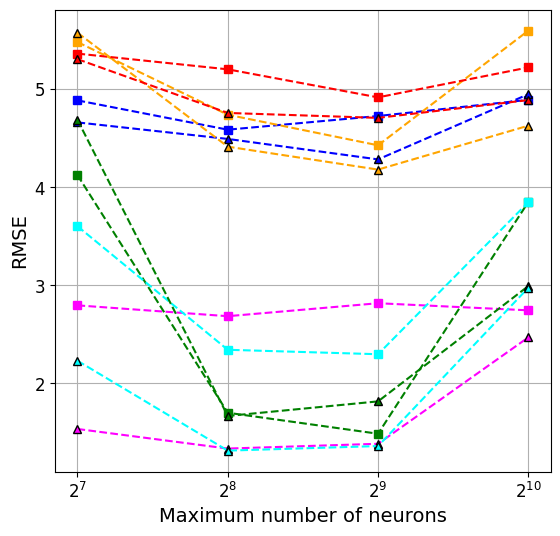

In [20]:
algorithms = ["FCM", "GKM"]
Ns = [128, 256, 512, 1024]
scenarios = ["B2B", "fiber0", "fiber9"]
OSNR = ["", "_woOSNR"]
neurons_scores = {f"scores_{algo}{osnr}_{scenario}":
                  [np.average(
                      eval(f"scores_{algo}_{N}{osnr}_{scenario}").get(
                          "rmse"
                      ).get(
                          "test"
                      )
                  ) for N in Ns]
                  for algo in algorithms
                  for osnr in OSNR 
                  for scenario in scenarios}

# Markers for algorithm 
markers = {"FCM": "s", "GKM": "^"}

# Colors for scenario (blue for B2B, orange for 0dBm, red for 9dBm)
colors = {"B2B": ["blue", "magenta"], "fiber0": ["orange", "green"], "fiber9": ["red", "cyan"]}

plt.figure(figsize=(8, 6), layout="constrained")
ax = plt.subplot(1, 1, 1)
for algo in algorithms:
    for scenario in scenarios:
        for osnr in OSNR:
            scenario_label = "Fiber @ 0 dBm" if scenario == "fiber0" else "Fiber @ 9 dBm" if scenario != "B2B" else scenario
            OSNR_label = "+ OSNR" if osnr == "" else ""
            label = f"{algo} {scenario_label} {OSNR_label}"
            color=colors.get(scenario)[0 if OSNR_label == "" else 1]
            marker = markers.get(algo)
            plt.plot(Ns, neurons_scores.get(f"scores_{algo}{osnr}_{scenario}"),
                     color=color, marker=marker, linestyle="--",
                     markeredgecolor="black" if algo == "GKM" else None,
                     label=f"{label}")
            plt.xscale("log", base=2)
plt.xlabel("Maximum number of neurons", fontsize=14)
plt.ylabel("RMSE", fontsize=14)
# Shrink current axis by 20%
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.tick_params(axis='both', labelsize=12)

plt.grid(True)

plt.savefig("neurons_rmse.svg", format="svg", transparent=True, bbox_inches="tight")

In [7]:
neurons_scores

{'scores_FCM_B2B': [2.7945438703355054,
  2.6839929596295073,
  2.8162220115245544,
  2.7438444607251826],
 'scores_FCM_fiber0': [4.123153926937511,
  1.6993594836298453,
  1.485347994901226,
  3.849145590683625],
 'scores_FCM_fiber9': [3.6016849217682667,
  2.341547687936834,
  2.2961832458410365,
  3.8467449615308325],
 'scores_FCM_woOSNR_B2B': [4.884758116798077,
  4.585902218353319,
  4.725237061624895,
  4.890365699790687],
 'scores_FCM_woOSNR_fiber0': [5.4795071780559095,
  4.738478428793924,
  4.426538216313256,
  5.596069801746688],
 'scores_FCM_woOSNR_fiber9': [5.36180650016618,
  5.201392960476919,
  4.915463311342551,
  5.220813465440021],
 'scores_GKM_B2B': [1.5339357544199752,
  1.334154509971668,
  1.3829906459703716,
  2.468412032011167],
 'scores_GKM_fiber0': [4.686833961060728,
  1.6665941923745762,
  1.815309476946839,
  2.9916149918260566],
 'scores_GKM_fiber9': [2.229913596374657,
  1.3131822914054567,
  1.3596853044167003,
  2.974377547901393],
 'scores_GKM_woOSNR_

## Comparación variando la primera función de activación (ReLu vs. Swish)

### B2B

In [74]:
args = {"data": df_FCM_B2B, "n_splits": 5, "max_neurons": 512, "activations": ["relu", "tanh", "sigmoid"]}
scores_FCM_relu_B2B = calc_once("scores_FCM_relu_B2B", test_estimation_model, args)

In [75]:
args = {"data": df_GKM_B2B, "n_splits": 5, "max_neurons": 512, "activations": ["relu", "tanh", "sigmoid"]}
scores_GKM_relu_B2B = calc_once("scores_GKM_relu_B2B", test_estimation_model, args)

In [76]:
args = {"data": df_FCM_B2B, "n_splits": 5, "max_neurons": 512, "activations": ["swish", "tanh", "sigmoid"]}
scores_FCM_swish_B2B = calc_once("scores_FCM_swish_B2B", test_estimation_model, args)

In [77]:
args = {"data": df_GKM_B2B, "n_splits": 5, "max_neurons": 512, "activations": ["swish", "tanh", "sigmoid"]}
scores_GKM_swish_B2B = calc_once("scores_GKM_swish_B2B", test_estimation_model, args)

In [78]:
%store scores_FCM_relu_B2B
%store scores_GKM_relu_B2B
%store scores_FCM_swish_B2B
%store scores_GKM_swish_B2B

Stored 'scores_FCM_relu_B2B' (dict)
Stored 'scores_GKM_relu_B2B' (dict)
Stored 'scores_FCM_swish_B2B' (dict)
Stored 'scores_GKM_swish_B2B' (dict)


In [79]:
#scores = [scores_FCM_relu_B2B, scores_GKM_relu_B2B, scores_FCM_swish_B2B, scores_GKM_swish_B2B]
#plot_activations_scores(scores, "ReLu vs. Swish, B2B")

### Fibra óptica a 0dBm

In [80]:
args = {"data": df_FCM_fiber0, "n_splits": 5, "max_neurons": 512, "activations": ["relu", "tanh", "sigmoid"]}
scores_FCM_relu_fiber0 = calc_once("scores_FCM_relu_fiber0", test_estimation_model, args)

In [81]:
args = {"data": df_GKM_fiber0, "n_splits": 5, "max_neurons": 512, "activations": ["relu", "tanh", "sigmoid"]}
scores_GKM_relu_fiber0 = calc_once("scores_GKM_relu_fiber0", test_estimation_model, args)

In [82]:
args = {"data": df_FCM_fiber0, "n_splits": 5, "max_neurons": 512, "activations": ["swish", "tanh", "sigmoid"]}
scores_FCM_swish_fiber0 = calc_once("scores_FCM_swish_fiber0", test_estimation_model, args)

In [83]:
args = {"data": df_GKM_fiber0, "n_splits": 5, "max_neurons": 512, "activations": ["swish", "tanh", "sigmoid"]}
scores_GKM_swish_fiber0 = calc_once("scores_GKM_swish_fiber0", test_estimation_model, args)

In [84]:
%store scores_FCM_relu_fiber0
%store scores_GKM_relu_fiber0
%store scores_FCM_swish_fiber0
%store scores_GKM_swish_fiber0

Stored 'scores_FCM_relu_fiber0' (dict)
Stored 'scores_GKM_relu_fiber0' (dict)
Stored 'scores_FCM_swish_fiber0' (dict)
Stored 'scores_GKM_swish_fiber0' (dict)


In [85]:
#scores = [scores_FCM_relu_fiber0, scores_GKM_relu_fiber0, scores_FCM_swish_fiber0, scores_GKM_swish_fiber0]
#plot_activations_scores(scores, "ReLu vs. Swish, optical fiber at 0dBm")

### Fibra óptica a 9dBm

In [86]:
args = {"data": df_FCM_fiber9, "n_splits": 5, "max_neurons": 512, "activations": ["relu", "tanh", "sigmoid"]}
scores_FCM_relu_fiber9 = calc_once("scores_FCM_relu_fiber9", test_estimation_model, args)

In [87]:
args = {"data": df_GKM_fiber9, "n_splits": 5, "max_neurons": 512, "activations": ["relu", "tanh", "sigmoid"]}
scores_GKM_relu_fiber9 = calc_once("scores_GKM_relu_fiber9", test_estimation_model, args)

In [88]:
args = {"data": df_FCM_fiber9, "n_splits": 5, "max_neurons": 512, "activations": ["swish", "tanh", "sigmoid"]}
scores_FCM_swish_fiber9 = calc_once("scores_FCM_swish_fiber9", test_estimation_model, args)

In [89]:
args = {"data": df_GKM_fiber9, "n_splits": 5, "max_neurons": 512, "activations": ["swish", "tanh", "sigmoid"]}
scores_GKM_swish_fiber9 = calc_once("scores_GKM_swish_fiber9", test_estimation_model, args)

In [90]:
%store scores_FCM_relu_fiber9
%store scores_GKM_relu_fiber9
%store scores_FCM_swish_fiber9
%store scores_GKM_swish_fiber9

Stored 'scores_FCM_relu_fiber9' (dict)
Stored 'scores_GKM_relu_fiber9' (dict)
Stored 'scores_FCM_swish_fiber9' (dict)
Stored 'scores_GKM_swish_fiber9' (dict)


In [91]:
#scores = [scores_FCM_relu_fiber9, scores_GKM_relu_fiber9, scores_FCM_swish_fiber9, scores_GKM_swish_fiber9]
#plot_activations_scores(scores, "ReLu vs. Swish, optical fiber at 9dBm")

## Comparación variando el número de capas ocultas (con OSNR)

### B2B

In [9]:
args = {"data": df_FCM_B2B, "n_splits": 5, "max_neurons": 512, "activations": ["relu"]}
scores_FCM_B2B_1HL = calc_once("scores_FCM_B2B_1HL", test_estimation_model, args)

In [10]:
args = {"data": df_GKM_B2B, "n_splits": 5, "max_neurons": 512, "activations": ["relu"]}
scores_GKM_B2B_1HL = calc_once("scores_GKM_B2B_1HL", test_estimation_model, args)

[{'units': 512, 'activation': 'relu'}]
Needed iterations: 617
7/7 [==============================] - 0s 775us/step
Needed iterations: 700
7/7 [==============================] - 0s 771us/step
Needed iterations: 619
7/7 [==============================] - 0s 879us/step
Needed iterations: 611
7/7 [==============================] - 0s 601us/step
Needed iterations: 807
7/7 [==============================] - 0s 741us/step
Time elapsed: 0.53 minutes


In [11]:
args = {"data": df_FCM_B2B, "n_splits": 5, "max_neurons": 512, "activations": ["relu", "sigmoid"]}
scores_FCM_B2B_2HL = calc_once("scores_FCM_B2B_2HL", test_estimation_model, args)

In [12]:
args = {"data": df_GKM_B2B, "n_splits": 5, "max_neurons": 512, "activations": ["relu", "sigmoid"]}
scores_GKM_B2B_2HL = calc_once("scores_GKM_B2B_2HL", test_estimation_model, args)

[{'units': 512, 'activation': 'relu'}, {'units': 256, 'activation': 'sigmoid'}]
Needed iterations: 939
7/7 [==============================] - 0s 876us/step
Needed iterations: 1102
7/7 [==============================] - 0s 826us/step
Needed iterations: 999
7/7 [==============================] - 0s 871us/step
Needed iterations: 759
7/7 [==============================] - 0s 757us/step
Needed iterations: 734
7/7 [==============================] - 0s 746us/step
Time elapsed: 1.55 minutes


In [13]:
args = {"data": df_FCM_B2B, "n_splits": 5, "max_neurons": 512, "activations": ["relu", "tanh", "sigmoid"]}
scores_FCM_B2B_3HL = calc_once("scores_FCM_B2B_3HL", test_estimation_model, args)

In [14]:
args = {"data": df_GKM_B2B, "n_splits": 5, "max_neurons": 512, "activations": ["relu", "tanh", "sigmoid"]}
scores_GKM_B2B_3HL = calc_once("scores_GKM_B2B_3HL", test_estimation_model, args)

[{'units': 512, 'activation': 'relu'}, {'units': 256, 'activation': 'tanh'}, {'units': 128, 'activation': 'sigmoid'}]
Needed iterations: 226
7/7 [==============================] - 0s 886us/step
Needed iterations: 359
7/7 [==============================] - 0s 964us/step
Needed iterations: 378
7/7 [==============================] - 0s 868us/step
Needed iterations: 255
7/7 [==============================] - 0s 928us/step
Needed iterations: 357
7/7 [==============================] - 0s 859us/step
Time elapsed: 0.63 minutes


In [15]:
args = {"data": df_FCM_B2B, "n_splits": 5, "max_neurons": 512, "activations": ["relu", "relu", "tanh", "sigmoid"]}
scores_FCM_B2B_4HL = calc_once("scores_FCM_B2B_4HL", test_estimation_model, args)

In [16]:
args = {"data": df_GKM_B2B, "n_splits": 5, "max_neurons": 512, "activations": ["relu", "relu", "tanh", "sigmoid"]}
scores_GKM_B2B_4HL = calc_once("scores_GKM_B2B_4HL", test_estimation_model, args)

[{'units': 512, 'activation': 'relu'}, {'units': 256, 'activation': 'relu'}, {'units': 128, 'activation': 'tanh'}, {'units': 64, 'activation': 'sigmoid'}]
Needed iterations: 121
7/7 [==============================] - 0s 924us/step
Needed iterations: 87
7/7 [==============================] - 0s 1ms/step
Needed iterations: 432
7/7 [==============================] - 0s 956us/step
Needed iterations: 114
7/7 [==============================] - 0s 955us/step
Needed iterations: 153
7/7 [==============================] - 0s 1ms/step
Time elapsed: 0.43 minutes


In [17]:
%store scores_FCM_B2B_1HL
%store scores_FCM_B2B_2HL
%store scores_FCM_B2B_3HL
%store scores_FCM_B2B_4HL

%store scores_GKM_B2B_1HL
%store scores_GKM_B2B_2HL
%store scores_GKM_B2B_3HL
%store scores_GKM_B2B_4HL

Stored 'scores_FCM_B2B_1HL' (dict)
Stored 'scores_FCM_B2B_2HL' (dict)
Stored 'scores_FCM_B2B_3HL' (dict)
Stored 'scores_FCM_B2B_4HL' (dict)
Stored 'scores_GKM_B2B_1HL' (dict)
Stored 'scores_GKM_B2B_2HL' (dict)
Stored 'scores_GKM_B2B_3HL' (dict)
Stored 'scores_GKM_B2B_4HL' (dict)


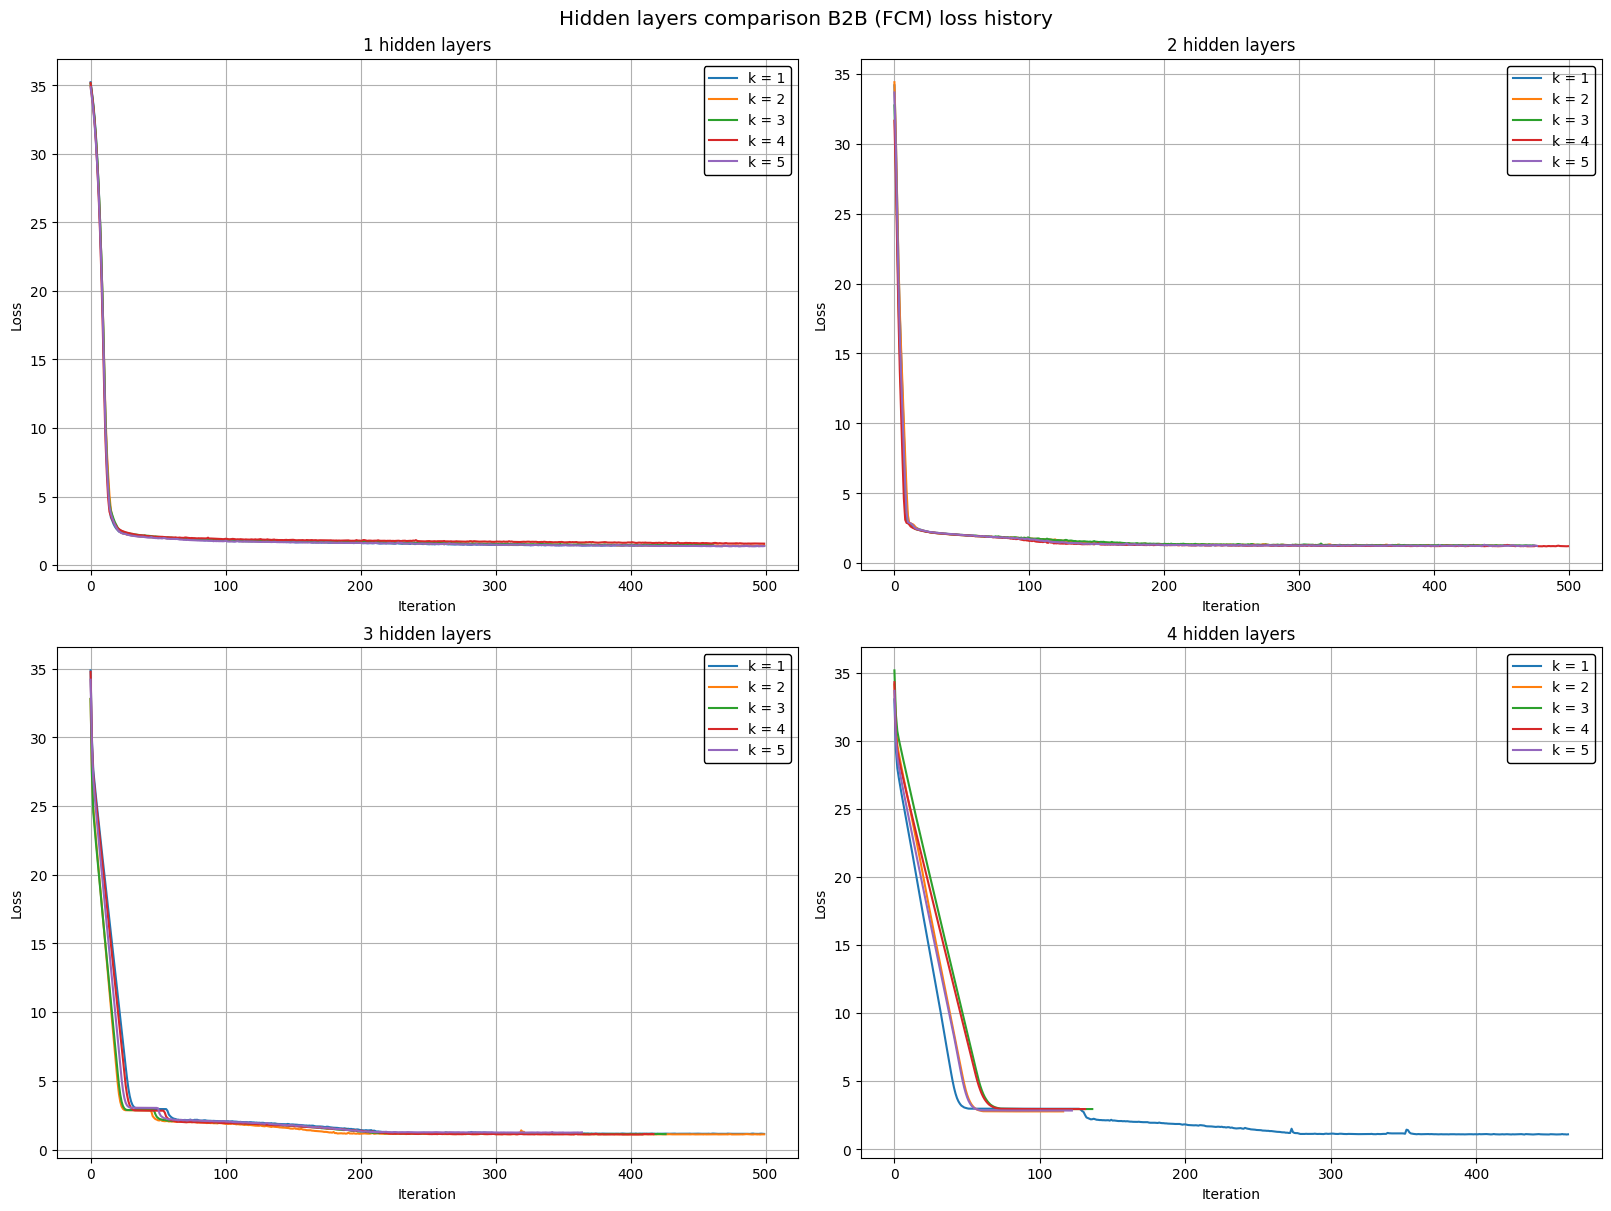

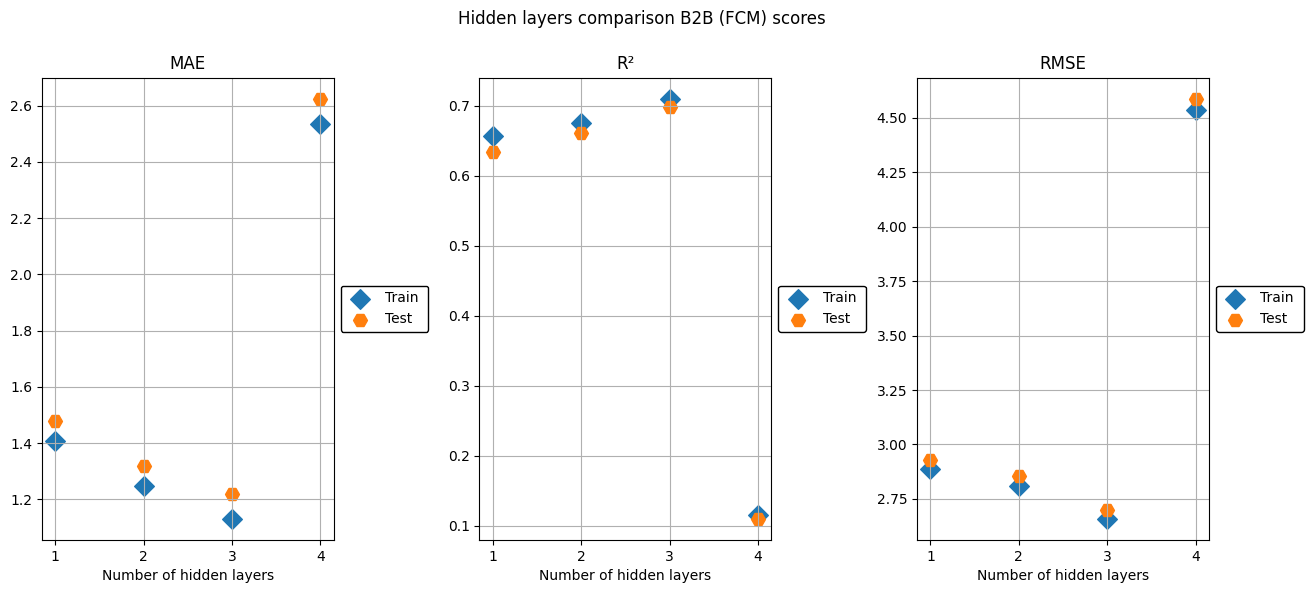

In [43]:
scores = [scores_FCM_B2B_1HL, scores_FCM_B2B_2HL, scores_FCM_B2B_3HL, scores_FCM_B2B_4HL]
plot_layers_scores(scores, "Hidden layers comparison B2B (FCM)")

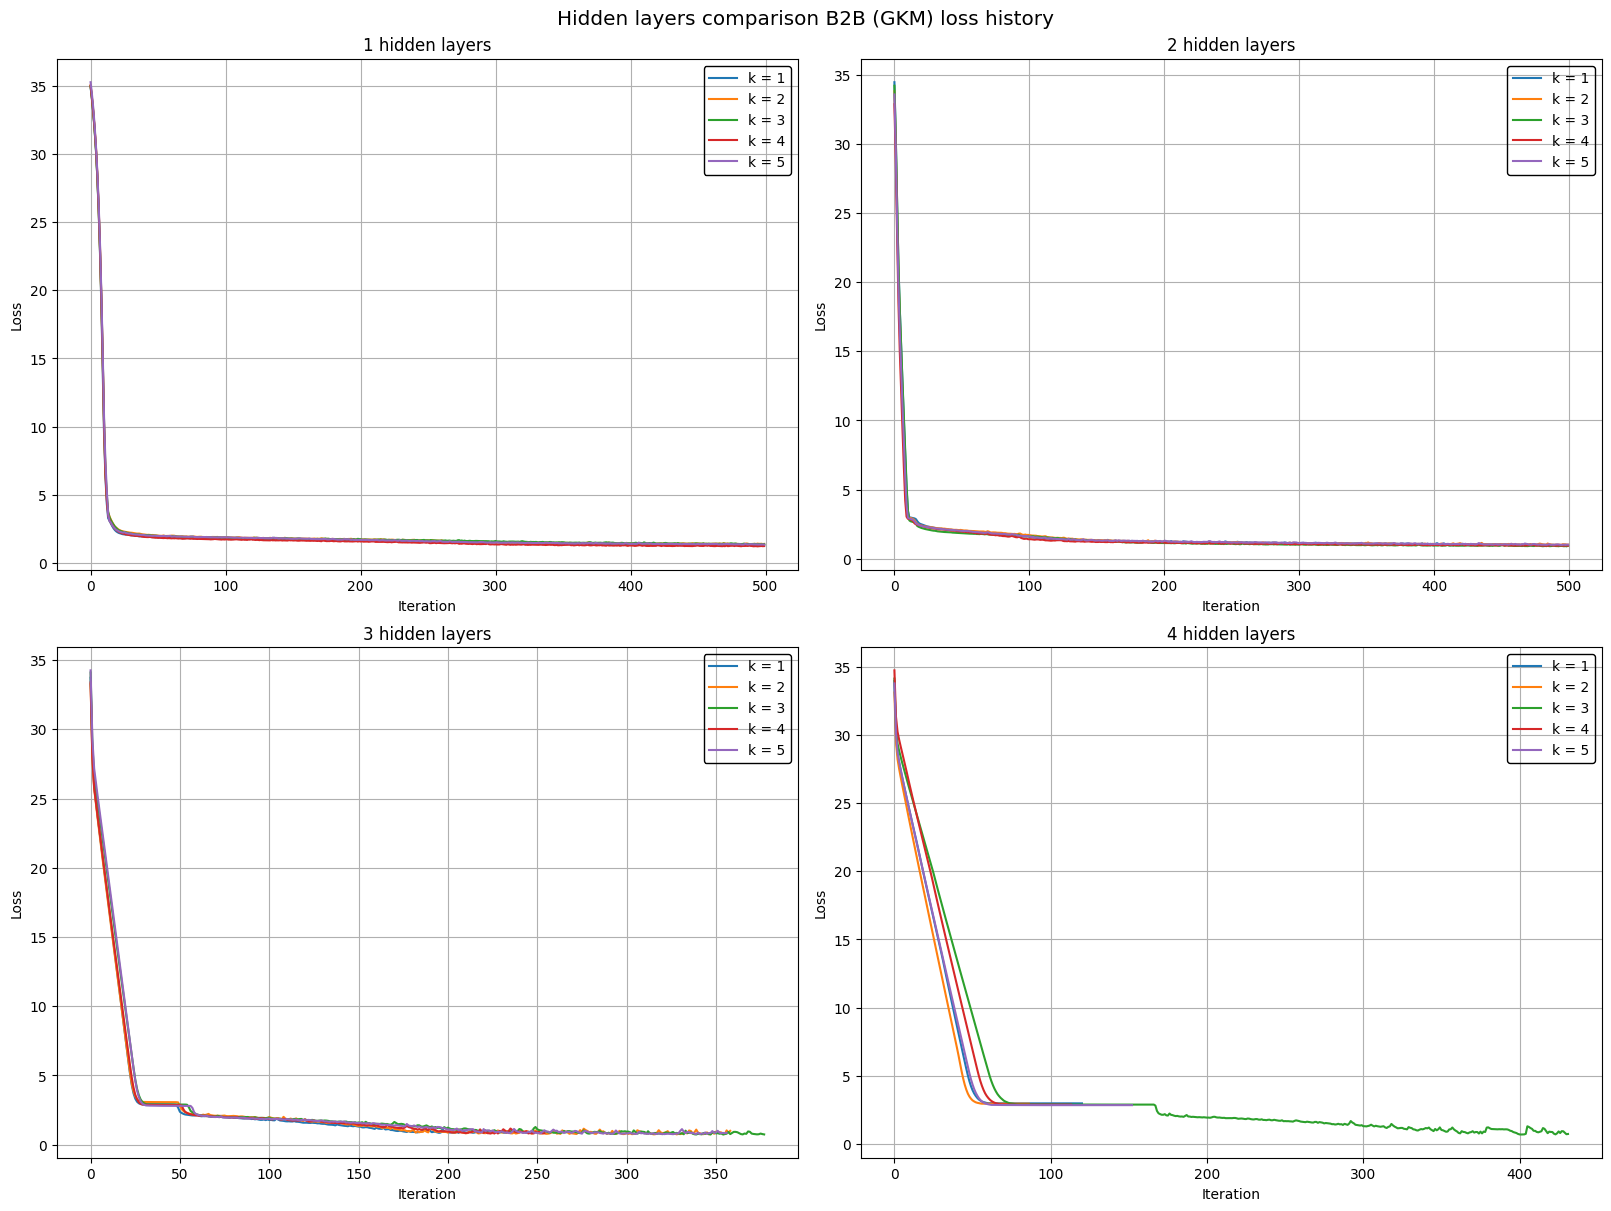

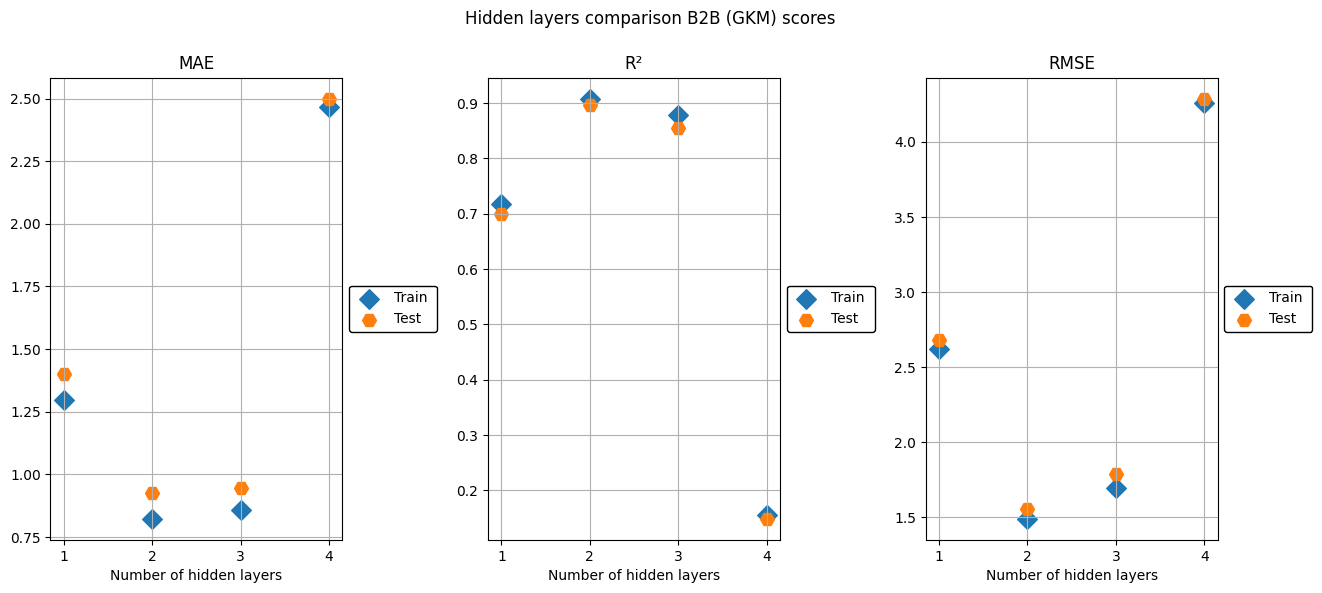

In [44]:
scores = [scores_GKM_B2B_1HL, scores_GKM_B2B_2HL, scores_GKM_B2B_3HL, scores_GKM_B2B_4HL]
plot_layers_scores(scores, "Hidden layers comparison B2B (GKM)")

### Fibra óptica a 0dBm

In [21]:
args = {"data": df_FCM_fiber0, "n_splits": 5, "max_neurons": 512, "activations": ["relu"]}
scores_FCM_fiber0_1HL = calc_once("scores_FCM_fiber0_1HL", test_estimation_model, args)

In [22]:
args = {"data": df_GKM_fiber0, "n_splits": 5, "max_neurons": 512, "activations": ["relu"]}
scores_GKM_fiber0_1HL = calc_once("scores_GKM_fiber0_1HL", test_estimation_model, args)

In [23]:
args = {"data": df_FCM_fiber0, "n_splits": 5, "max_neurons": 512, "activations": ["relu", "sigmoid"]}
scores_FCM_fiber0_2HL = calc_once("scores_FCM_fiber0_2HL", test_estimation_model, args)

In [24]:
args = {"data": df_GKM_fiber0, "n_splits": 5, "max_neurons": 512, "activations": ["relu", "sigmoid"]}
scores_GKM_fiber0_2HL = calc_once("scores_GKM_fiber0_2HL", test_estimation_model, args)

In [25]:
args = {"data": df_FCM_fiber0, "n_splits": 5, "max_neurons": 512, "activations": ["relu", "tanh", "sigmoid"]}
scores_FCM_fiber0_3HL = calc_once("scores_FCM_fiber0_3HL", test_estimation_model, args)

In [26]:
args = {"data": df_GKM_fiber0, "n_splits": 5, "max_neurons": 512, "activations": ["relu", "tanh", "sigmoid"]}
scores_GKM_fiber0_3HL = calc_once("scores_GKM_fiber0_3HL", test_estimation_model, args)

In [27]:
args = {"data": df_FCM_fiber0, "n_splits": 5, "max_neurons": 512, "activations": ["relu", "relu", "tanh", "sigmoid"]}
scores_FCM_fiber0_4HL = calc_once("scores_FCM_fiber0_4HL", test_estimation_model, args)

In [28]:
args = {"data": df_GKM_fiber0, "n_splits": 5, "max_neurons": 512, "activations": ["relu", "relu", "tanh", "sigmoid"]}
scores_GKM_fiber0_4HL = calc_once("scores_GKM_fiber0_4HL", test_estimation_model, args)

In [29]:
%store scores_FCM_fiber0_1HL
%store scores_FCM_fiber0_2HL
%store scores_FCM_fiber0_3HL
%store scores_FCM_fiber0_4HL

%store scores_GKM_fiber0_1HL
%store scores_GKM_fiber0_2HL
%store scores_GKM_fiber0_3HL
%store scores_GKM_fiber0_4HL

Stored 'scores_FCM_fiber0_1HL' (dict)
Stored 'scores_FCM_fiber0_2HL' (dict)
Stored 'scores_FCM_fiber0_3HL' (dict)
Stored 'scores_FCM_fiber0_4HL' (dict)
Stored 'scores_GKM_fiber0_1HL' (dict)
Stored 'scores_GKM_fiber0_2HL' (dict)
Stored 'scores_GKM_fiber0_3HL' (dict)
Stored 'scores_GKM_fiber0_4HL' (dict)


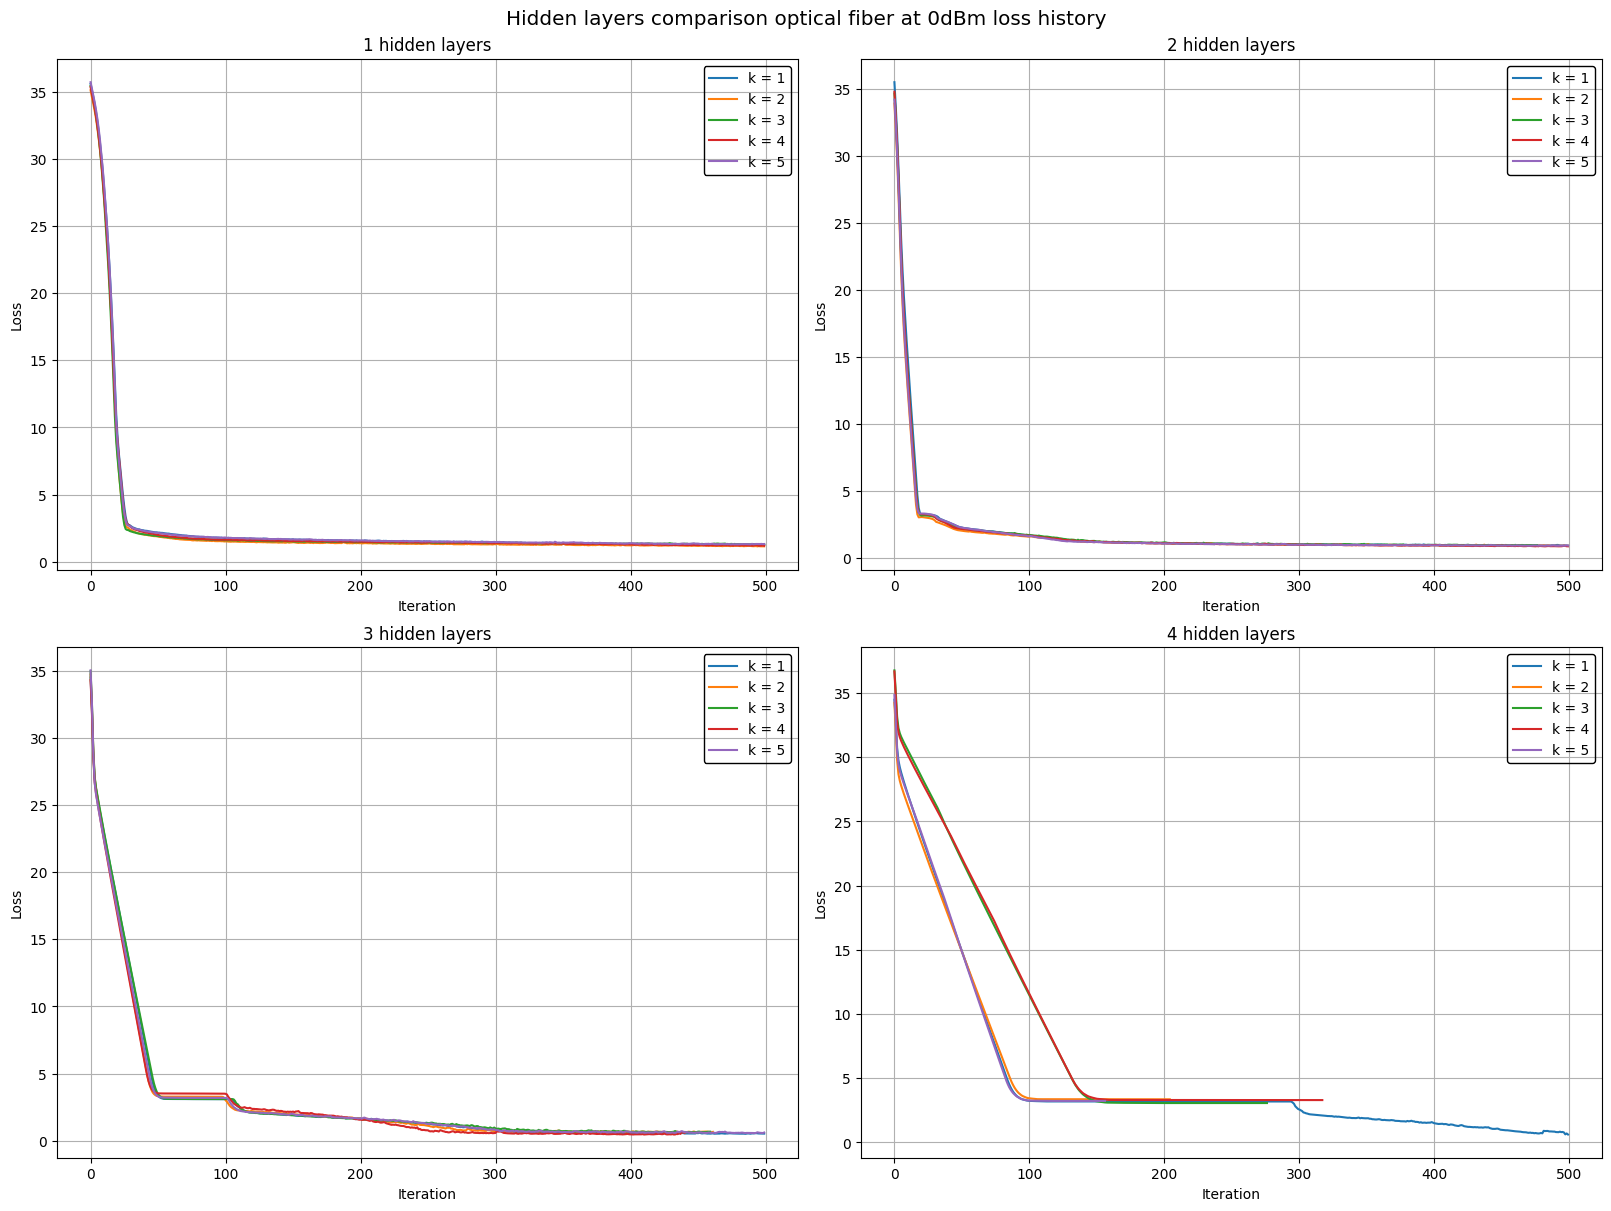

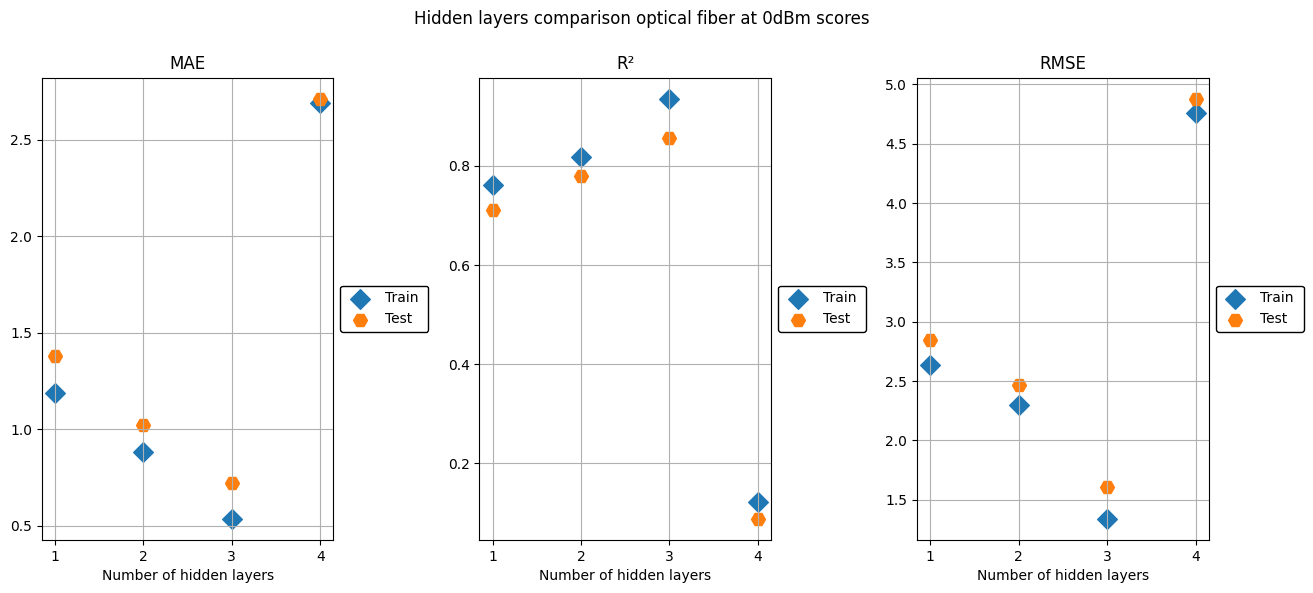

In [30]:
scores = [scores_FCM_fiber0_1HL, scores_FCM_fiber0_2HL, scores_FCM_fiber0_3HL, scores_FCM_fiber0_4HL]
plot_layers_scores(scores, "Hidden layers comparison optical fiber at 0dBm")

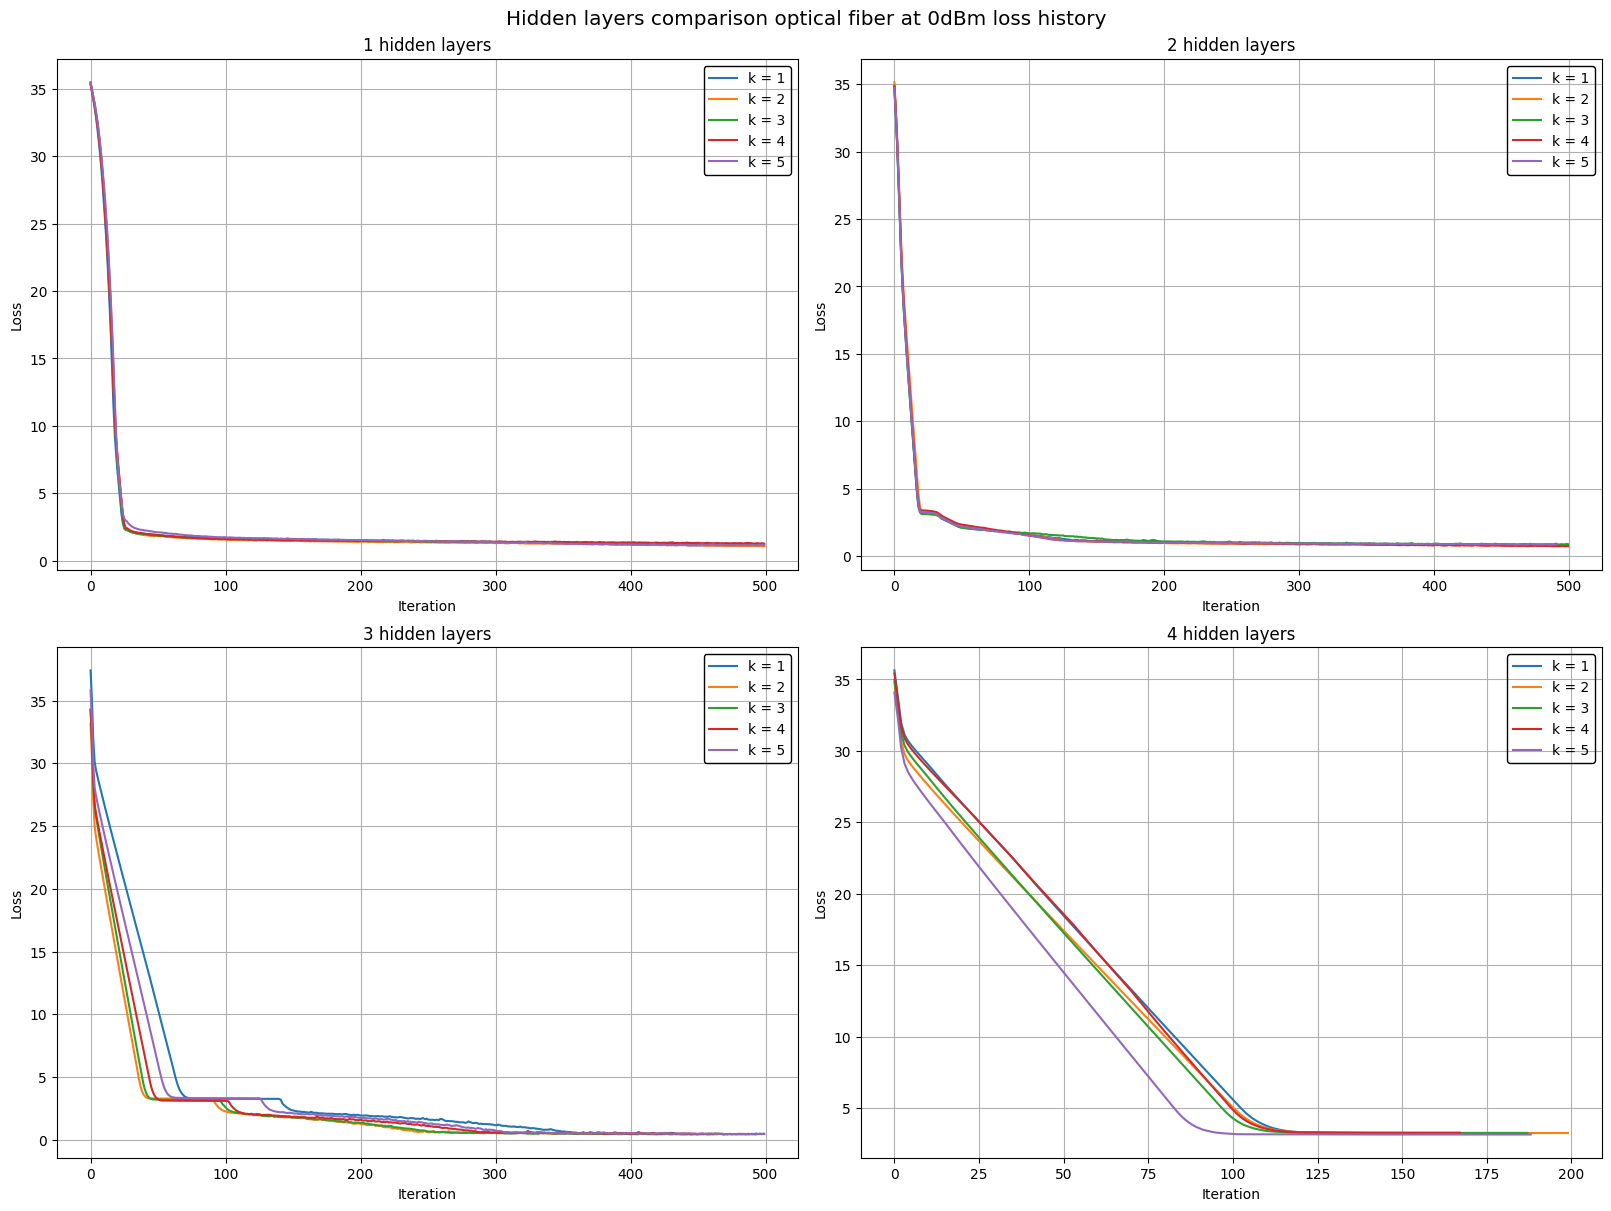

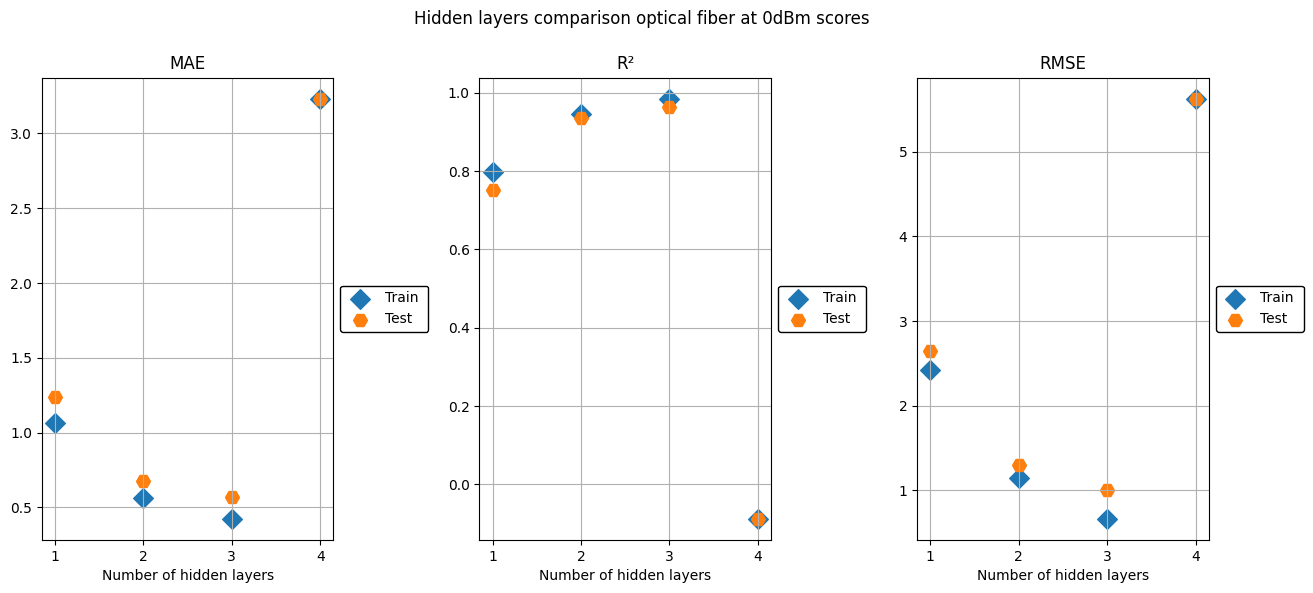

In [31]:
scores = [scores_GKM_fiber0_1HL, scores_GKM_fiber0_2HL, scores_GKM_fiber0_3HL, scores_GKM_fiber0_4HL]
plot_layers_scores(scores, "Hidden layers comparison optical fiber at 0dBm")

### Fibra óptica a 9dBm

In [32]:
args = {"data": df_FCM_fiber9, "n_splits": 5, "max_neurons": 512, "activations": ["relu"]}
scores_FCM_fiber9_1HL = calc_once("scores_FCM_fiber9_1HL", test_estimation_model, args)

In [33]:
args = {"data": df_GKM_fiber9, "n_splits": 5, "max_neurons": 512, "activations": ["relu"]}
scores_GKM_fiber9_1HL = calc_once("scores_GKM_fiber9_1HL", test_estimation_model, args)

In [34]:
args = {"data": df_FCM_fiber9, "n_splits": 5, "max_neurons": 512, "activations": ["relu", "sigmoid"]}
scores_FCM_fiber9_2HL = calc_once("scores_FCM_fiber9_2HL", test_estimation_model, args)

In [35]:
args = {"data": df_GKM_fiber9, "n_splits": 5, "max_neurons": 512, "activations": ["relu", "sigmoid"]}
scores_GKM_fiber9_2HL = calc_once("scores_GKM_fiber9_2HL", test_estimation_model, args)

In [36]:
args = {"data": df_FCM_fiber9, "n_splits": 5, "max_neurons": 512, "activations": ["relu", "tanh", "sigmoid"]}
scores_FCM_fiber9_3HL = calc_once("scores_FCM_fiber9_3HL", test_estimation_model, args)

In [37]:
args = {"data": df_GKM_fiber9, "n_splits": 5, "max_neurons": 512, "activations": ["relu", "tanh", "sigmoid"]}
scores_GKM_fiber9_3HL = calc_once("scores_GKM_fiber9_3HL", test_estimation_model, args)

In [38]:
args = {"data": df_FCM_fiber9, "n_splits": 5, "max_neurons": 512, "activations": ["relu", "relu", "tanh", "sigmoid"]}
scores_FCM_fiber9_4HL = calc_once("scores_FCM_fiber9_4HL", test_estimation_model, args)

In [39]:
args = {"data": df_GKM_fiber9, "n_splits": 5, "max_neurons": 512, "activations": ["relu", "relu", "tanh", "sigmoid"]}
scores_GKM_fiber9_4HL = calc_once("scores_GKM_fiber9_4HL", test_estimation_model, args)

In [40]:
%store scores_FCM_fiber9_1HL
%store scores_FCM_fiber9_2HL
%store scores_FCM_fiber9_3HL
%store scores_FCM_fiber9_4HL

%store scores_GKM_fiber9_1HL
%store scores_GKM_fiber9_2HL
%store scores_GKM_fiber9_3HL
%store scores_GKM_fiber9_4HL

Stored 'scores_FCM_fiber9_1HL' (dict)
Stored 'scores_FCM_fiber9_2HL' (dict)
Stored 'scores_FCM_fiber9_3HL' (dict)
Stored 'scores_FCM_fiber9_4HL' (dict)
Stored 'scores_GKM_fiber9_1HL' (dict)
Stored 'scores_GKM_fiber9_2HL' (dict)
Stored 'scores_GKM_fiber9_3HL' (dict)
Stored 'scores_GKM_fiber9_4HL' (dict)


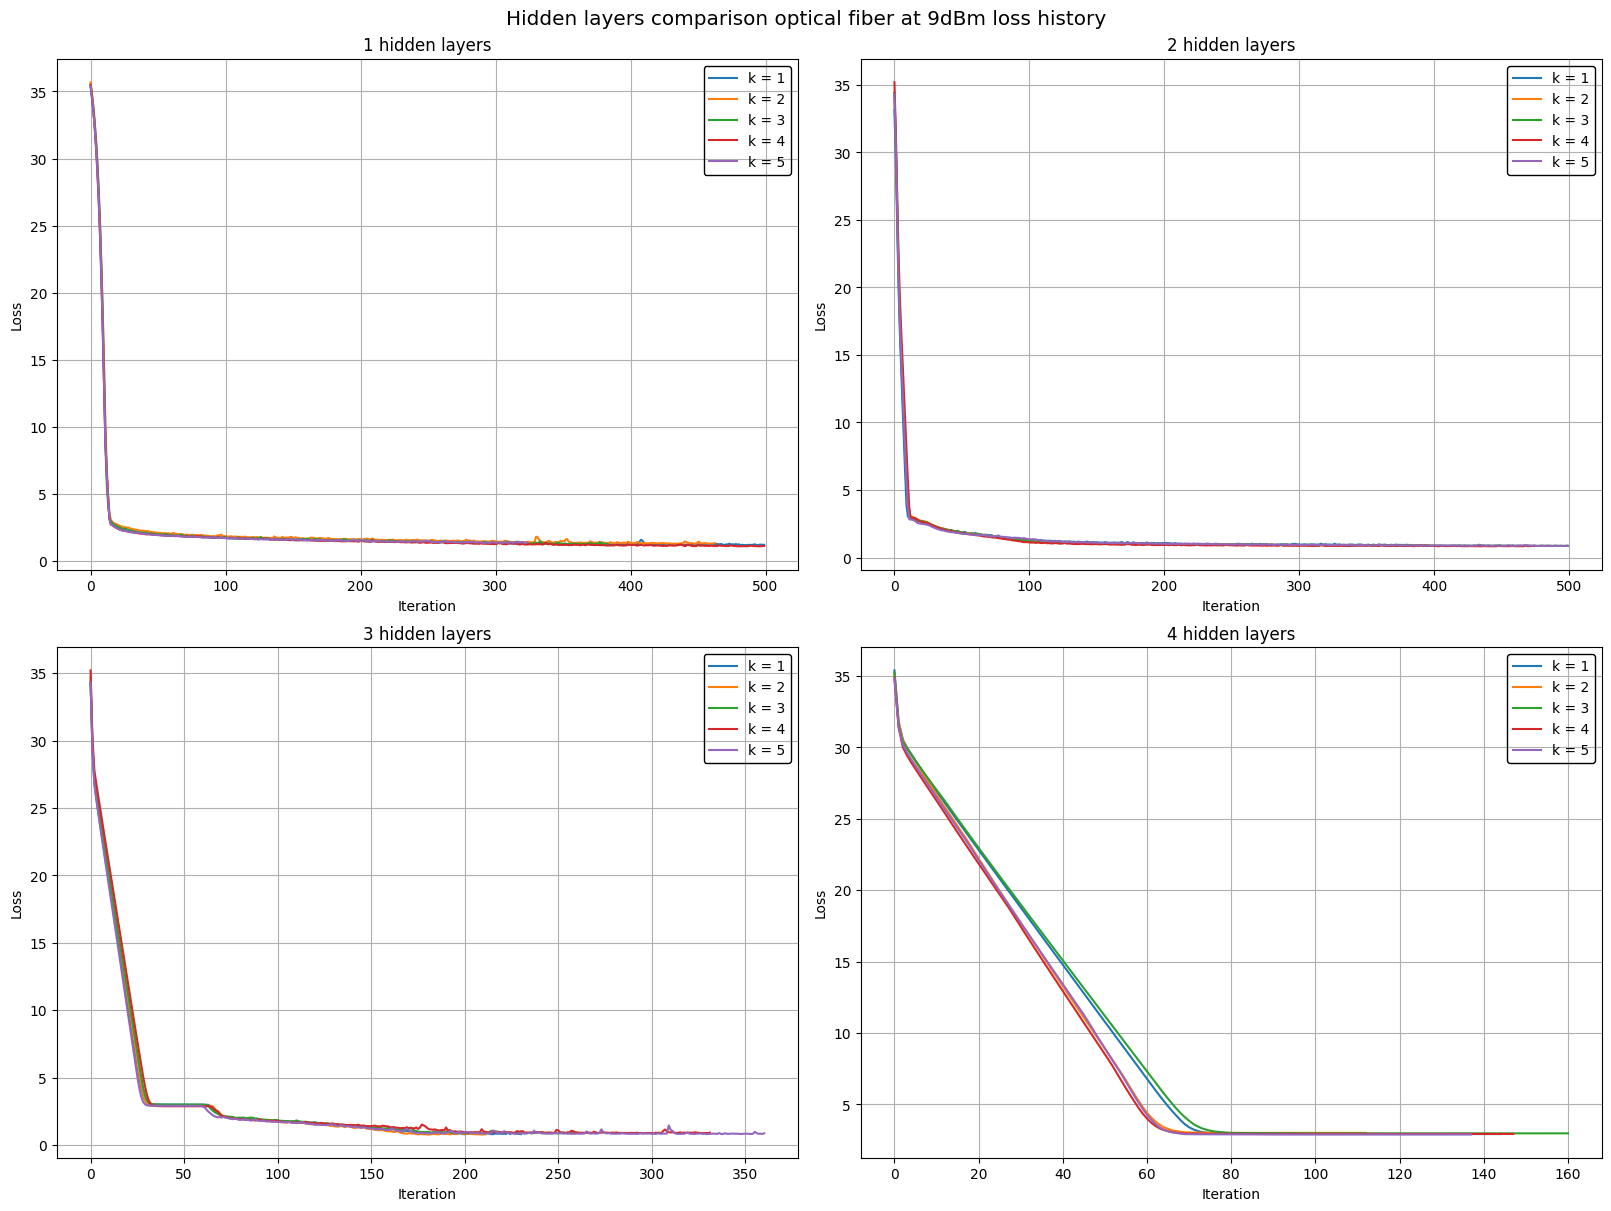

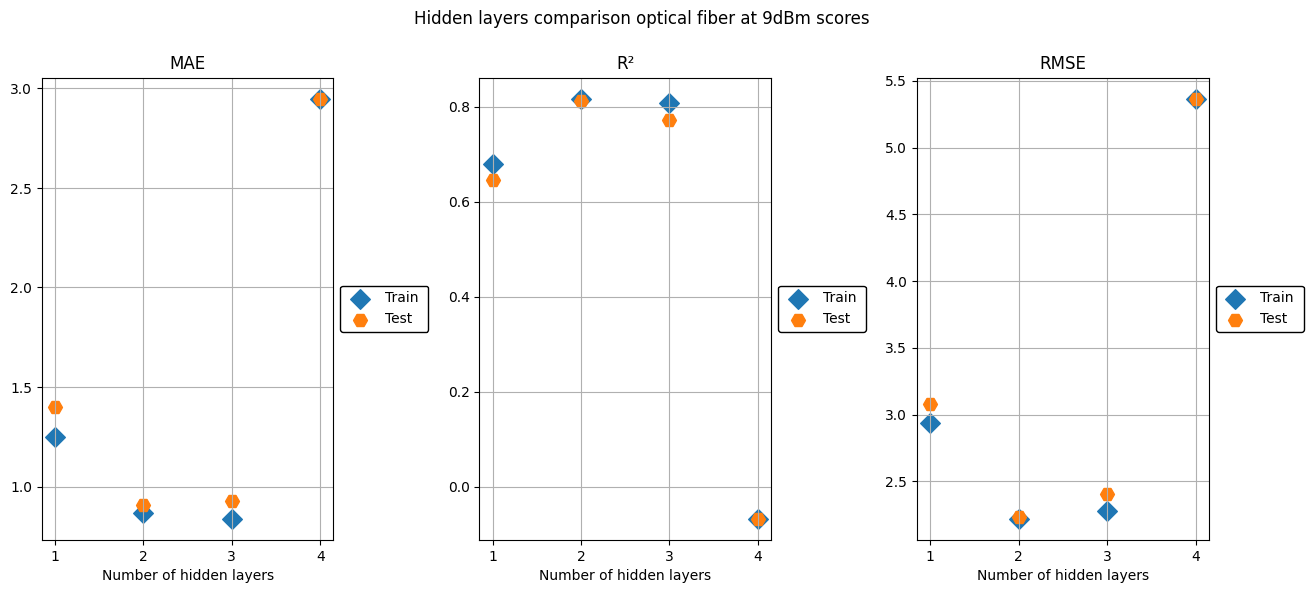

In [41]:
scores = [scores_FCM_fiber9_1HL, scores_FCM_fiber9_2HL, scores_FCM_fiber9_3HL, scores_FCM_fiber9_4HL]
plot_layers_scores(scores, "Hidden layers comparison optical fiber at 9dBm")

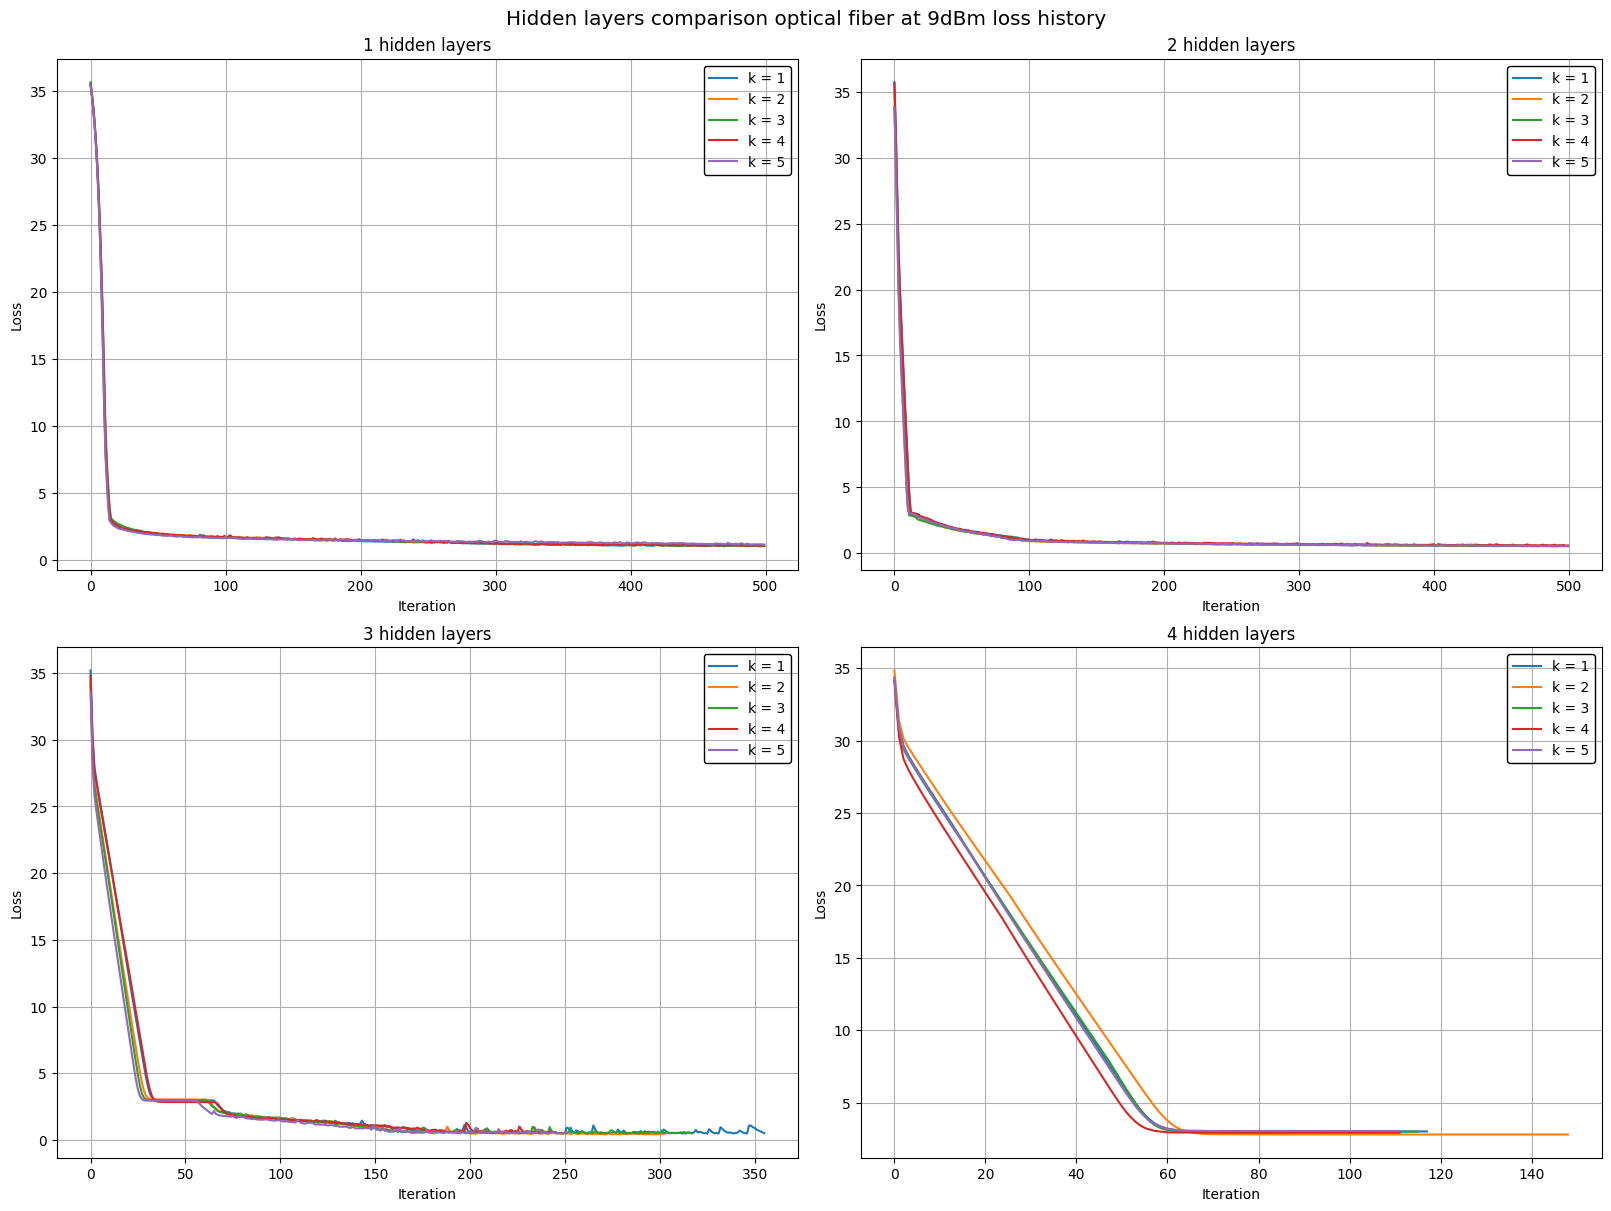

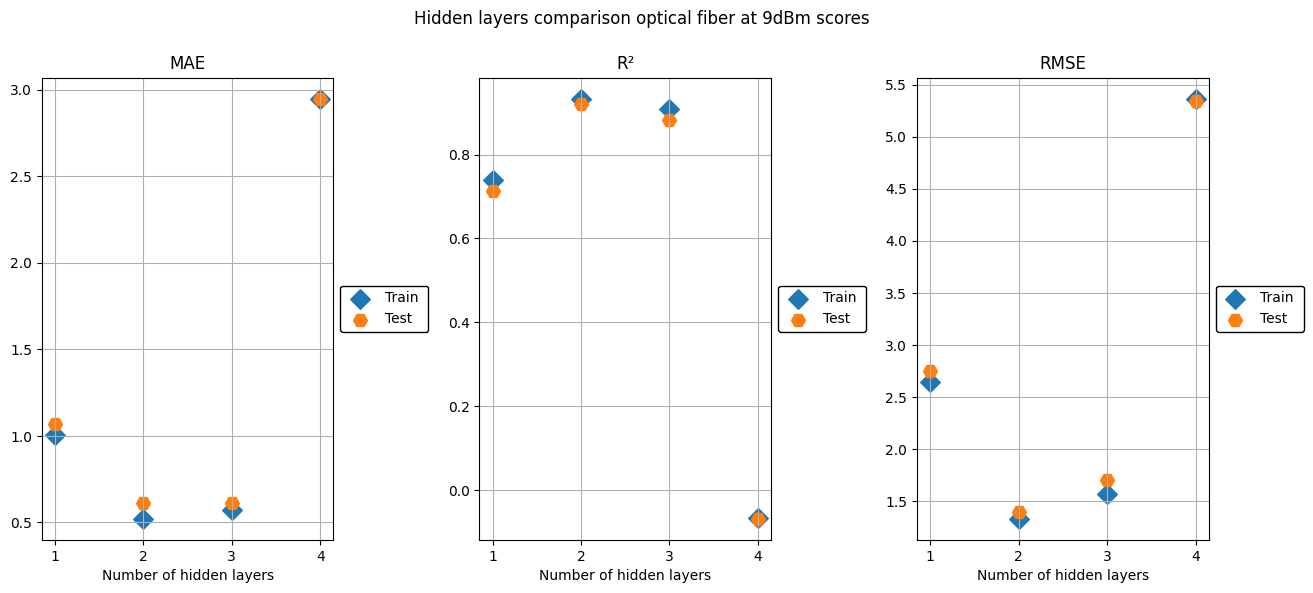

In [42]:
scores = [scores_GKM_fiber9_1HL, scores_GKM_fiber9_2HL, scores_GKM_fiber9_3HL, scores_GKM_fiber9_4HL]
plot_layers_scores(scores, "Hidden layers comparison optical fiber at 9dBm")

## Comparación variando el número de capas ocultas (sin OSNR)

### B2B

In [75]:
args = {"data": df_FCM_B2B, "n_splits": 5, "max_neurons": 512, "activations": ["relu"], "use_osnr": False}
scores_FCM_B2B_1HL_woOSNR = calc_once("scores_FCM_B2B_1HL_woOSNR", test_estimation_model, args)

In [76]:
args = {"data": df_GKM_B2B, "n_splits": 5, "max_neurons": 512, "activations": ["relu"], "use_osnr": False}
scores_GKM_B2B_1HL_woOSNR = calc_once("scores_GKM_B2B_1HL_woOSNR", test_estimation_model, args)

[{'units': 512, 'activation': 'relu'}]
Needed iterations: 244
7/7 [==============================] - 0s 596us/step
Needed iterations: 132
7/7 [==============================] - 0s 655us/step
Needed iterations: 290
7/7 [==============================] - 0s 667us/step
Needed iterations: 233
7/7 [==============================] - 0s 647us/step
Needed iterations: 543
7/7 [==============================] - 0s 629us/step
Time elapsed: 0.26 minutes


In [77]:
args = {"data": df_FCM_B2B, "n_splits": 5, "max_neurons": 512, "activations": ["relu", "sigmoid"], "use_osnr": False}
scores_FCM_B2B_2HL_woOSNR = calc_once("scores_FCM_B2B_2HL_woOSNR", test_estimation_model, args)

In [78]:
args = {"data": df_GKM_B2B, "n_splits": 5, "max_neurons": 512, "activations": ["relu", "sigmoid"], "use_osnr": False}
scores_GKM_B2B_2HL_woOSNR = calc_once("scores_GKM_B2B_2HL_woOSNR", test_estimation_model, args)

[{'units': 512, 'activation': 'relu'}, {'units': 256, 'activation': 'sigmoid'}]
Needed iterations: 254
7/7 [==============================] - 0s 796us/step
Needed iterations: 270
7/7 [==============================] - 0s 1ms/step
Needed iterations: 311
7/7 [==============================] - 0s 1ms/step
Needed iterations: 300
7/7 [==============================] - 0s 818us/step
Needed iterations: 255
7/7 [==============================] - 0s 960us/step
Time elapsed: 0.51 minutes


In [79]:
args = {"data": df_FCM_B2B, "n_splits": 5, "max_neurons": 512, "activations": ["relu", "tanh", "sigmoid"], "use_osnr": False}
scores_FCM_B2B_3HL_woOSNR = calc_once("scores_FCM_B2B_3HL_woOSNR", test_estimation_model, args)

In [80]:
args = {"data": df_GKM_B2B, "n_splits": 5, "max_neurons": 512, "activations": ["relu", "tanh", "sigmoid"], "use_osnr": False}
scores_GKM_B2B_3HL_woOSNR = calc_once("scores_GKM_B2B_3HL_woOSNR", test_estimation_model, args)

[{'units': 512, 'activation': 'relu'}, {'units': 256, 'activation': 'tanh'}, {'units': 128, 'activation': 'sigmoid'}]
Needed iterations: 546
7/7 [==============================] - 0s 798us/step
Needed iterations: 527
7/7 [==============================] - 0s 896us/step
Needed iterations: 585
7/7 [==============================] - 0s 869us/step
Needed iterations: 665
7/7 [==============================] - 0s 1ms/step
Needed iterations: 346
7/7 [==============================] - 0s 808us/step
Time elapsed: 1.08 minutes


In [81]:
args = {"data": df_FCM_B2B, "n_splits": 5, "max_neurons": 512, "activations": ["relu", "relu", "tanh", "sigmoid"], "use_osnr": False}
scores_FCM_B2B_4HL_woOSNR = calc_once("scores_FCM_B2B_4HL_woOSNR", test_estimation_model, args)

In [82]:
args = {"data": df_GKM_B2B, "n_splits": 5, "max_neurons": 512, "activations": ["relu", "relu", "tanh", "sigmoid"], "use_osnr": False}
scores_GKM_B2B_4HL_woOSNR = calc_once("scores_GKM_B2B_4HL_woOSNR", test_estimation_model, args)

[{'units': 512, 'activation': 'relu'}, {'units': 256, 'activation': 'relu'}, {'units': 128, 'activation': 'tanh'}, {'units': 64, 'activation': 'sigmoid'}]
Needed iterations: 137
7/7 [==============================] - 0s 1ms/step
Needed iterations: 99
7/7 [==============================] - 0s 1ms/step
Needed iterations: 141
7/7 [==============================] - 0s 1ms/step
Needed iterations: 120
7/7 [==============================] - 0s 1ms/step
Needed iterations: 144
7/7 [==============================] - 0s 986us/step
Time elapsed: 0.34 minutes


In [83]:
%store scores_FCM_B2B_1HL_woOSNR
%store scores_FCM_B2B_2HL_woOSNR
%store scores_FCM_B2B_3HL_woOSNR
%store scores_FCM_B2B_4HL_woOSNR

%store scores_GKM_B2B_1HL_woOSNR
%store scores_GKM_B2B_2HL_woOSNR
%store scores_GKM_B2B_3HL_woOSNR
%store scores_GKM_B2B_4HL_woOSNR

Stored 'scores_FCM_B2B_1HL_woOSNR' (dict)
Stored 'scores_FCM_B2B_2HL_woOSNR' (dict)
Stored 'scores_FCM_B2B_3HL_woOSNR' (dict)
Stored 'scores_FCM_B2B_4HL_woOSNR' (dict)
Stored 'scores_GKM_B2B_1HL_woOSNR' (dict)
Stored 'scores_GKM_B2B_2HL_woOSNR' (dict)
Stored 'scores_GKM_B2B_3HL_woOSNR' (dict)
Stored 'scores_GKM_B2B_4HL_woOSNR' (dict)


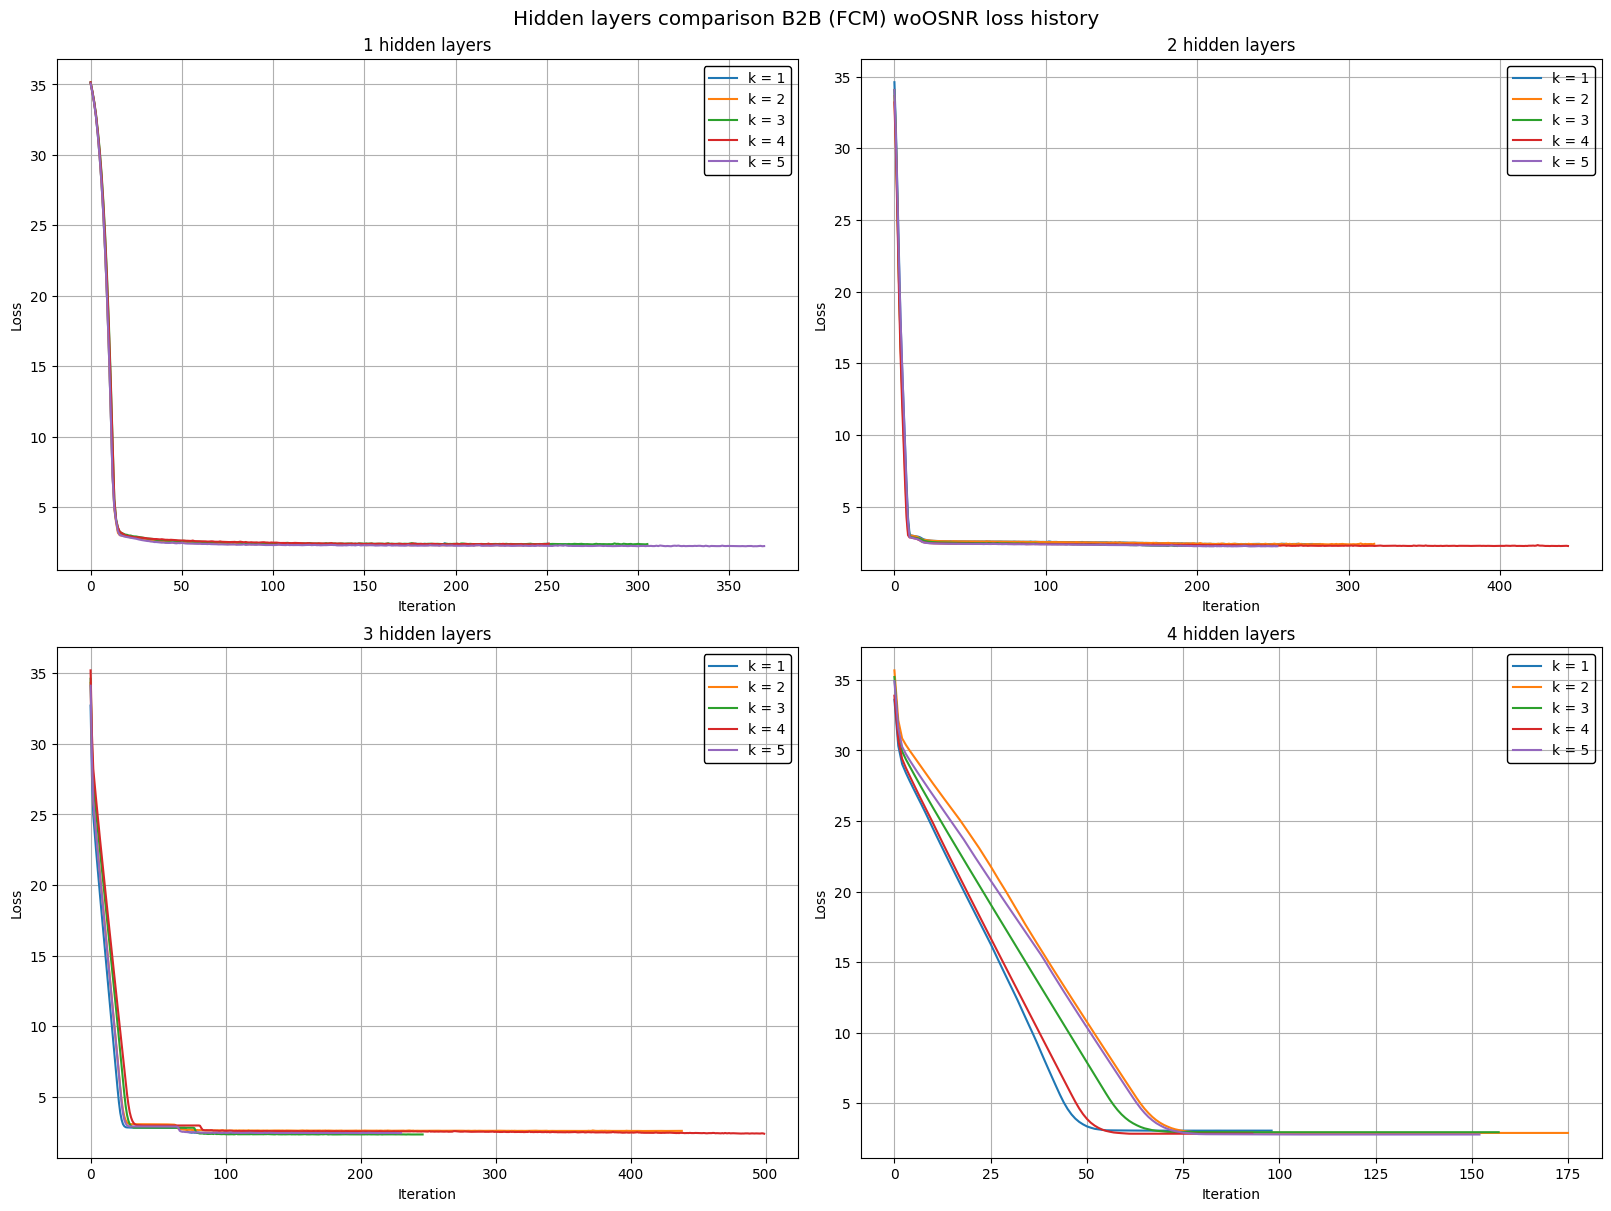

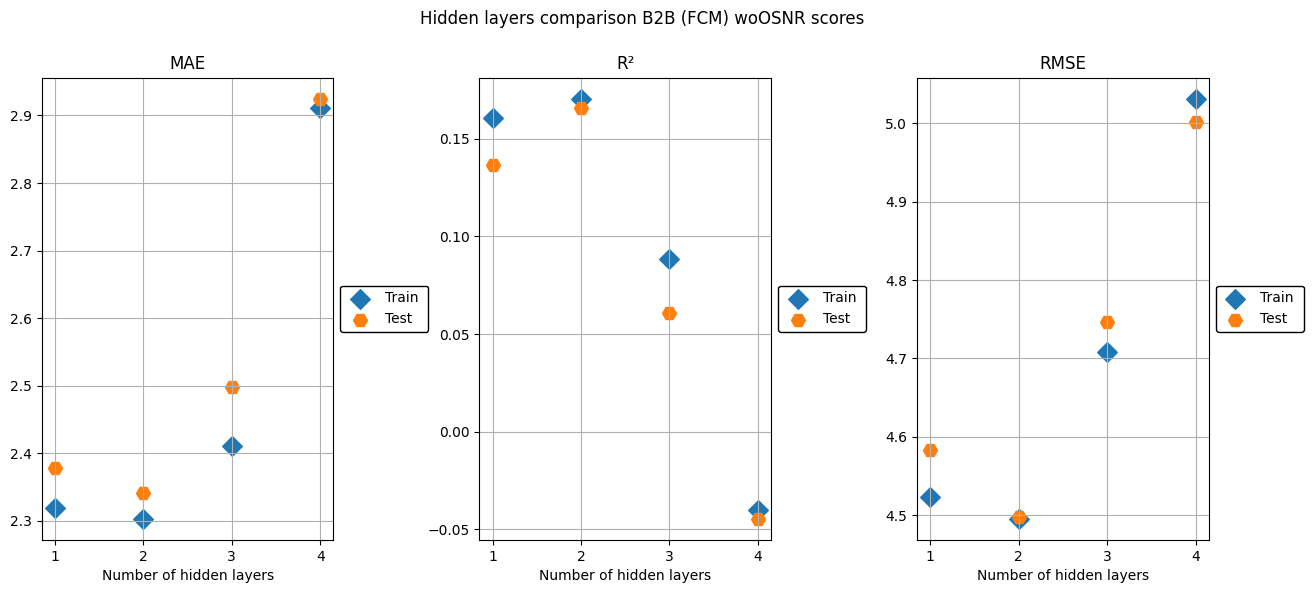

In [5]:
scores = [scores_FCM_B2B_1HL_woOSNR, scores_FCM_B2B_2HL_woOSNR, scores_FCM_B2B_3HL_woOSNR, scores_FCM_B2B_4HL_woOSNR]
plot_layers_scores(scores, "Hidden layers comparison B2B (FCM) woOSNR")

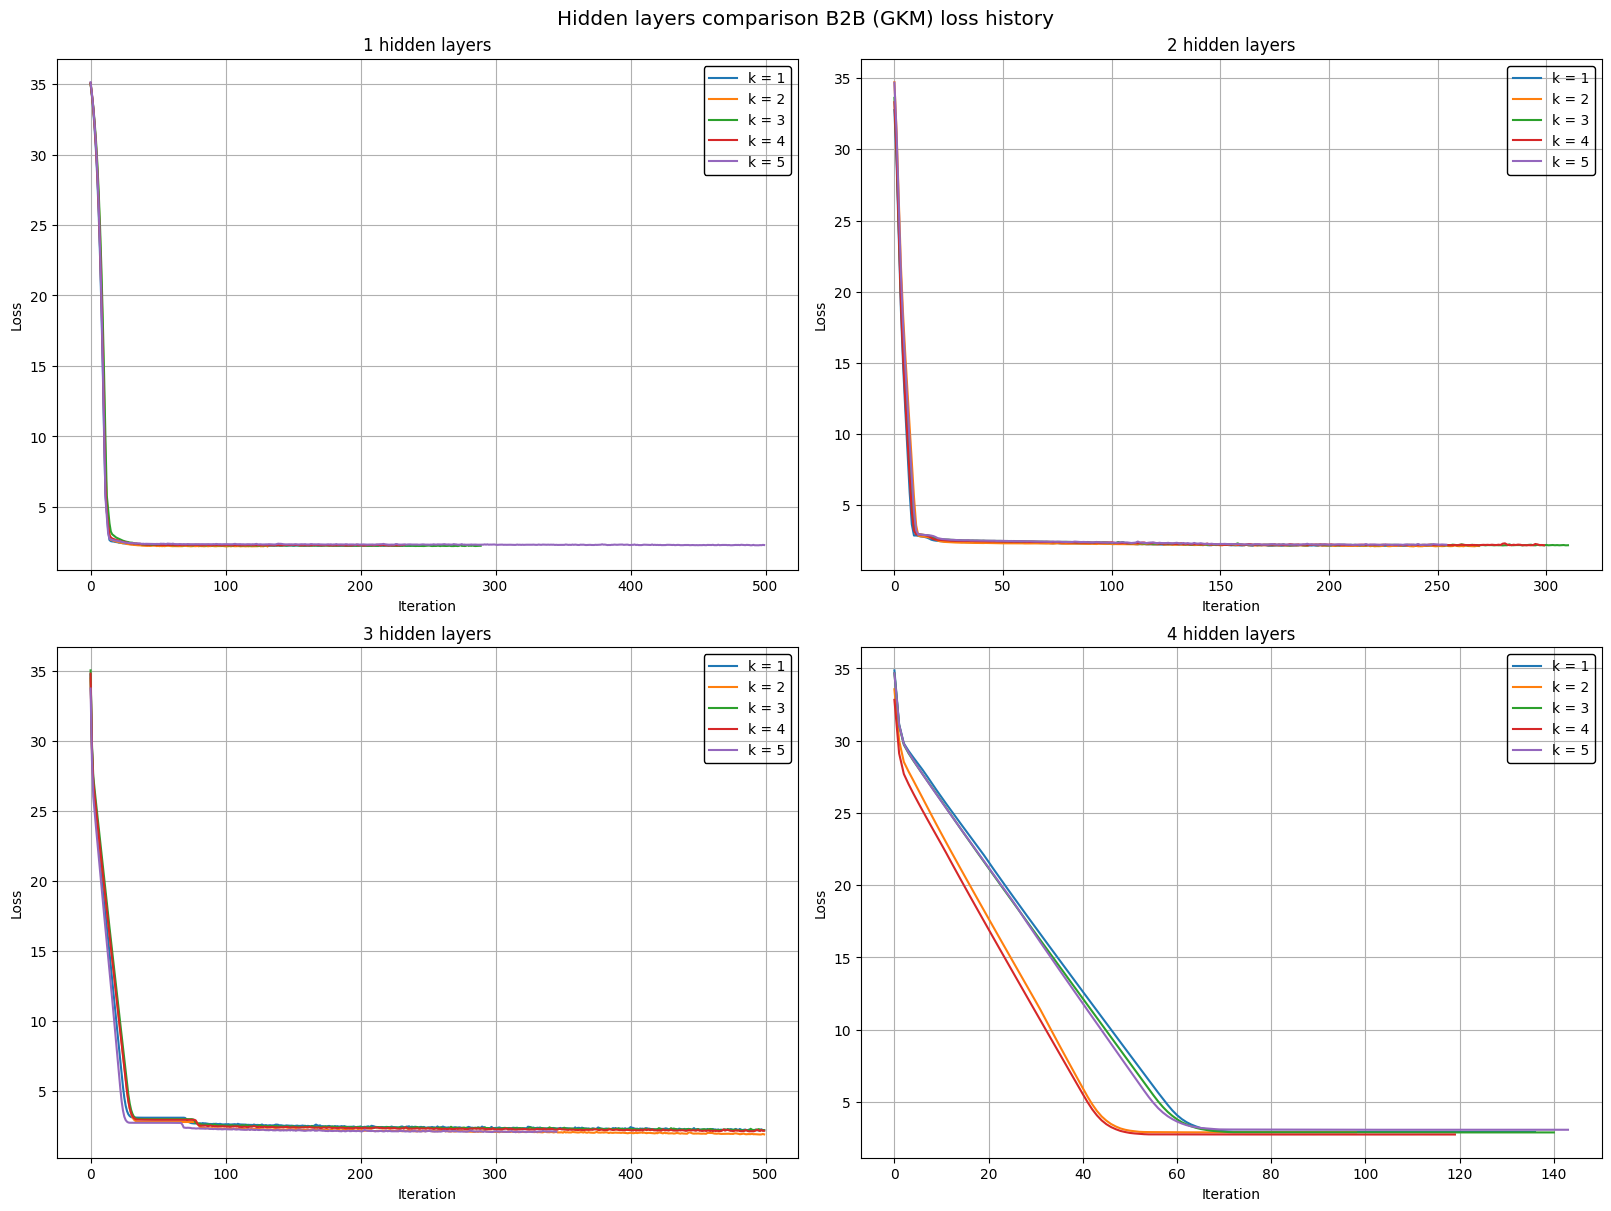

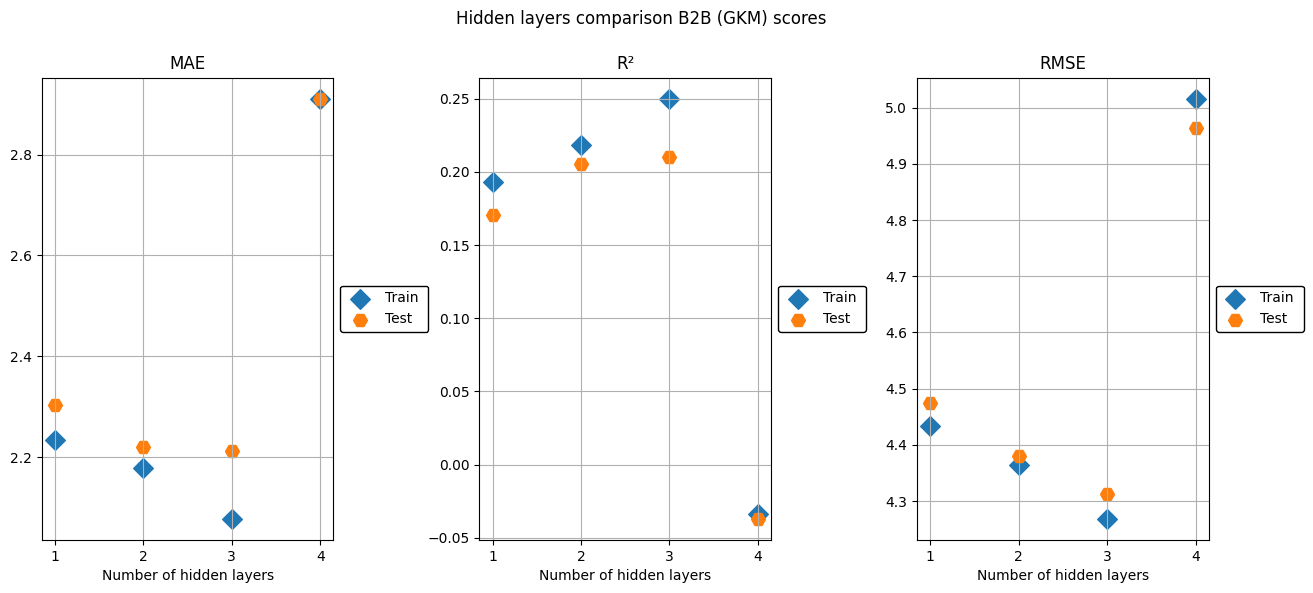

In [6]:
scores = [scores_GKM_B2B_1HL_woOSNR, scores_GKM_B2B_2HL_woOSNR, scores_GKM_B2B_3HL_woOSNR, scores_GKM_B2B_4HL_woOSNR]
plot_layers_scores(scores, "Hidden layers comparison B2B (GKM)")

### Fibra óptica a 0dBm

In [84]:
args = {"data": df_FCM_fiber0, "n_splits": 5, "max_neurons": 512, "activations": ["relu"], "use_osnr": False}
scores_FCM_fiber0_1HL_woOSNR = calc_once("scores_FCM_fiber0_1HL_woOSNR", test_estimation_model, args)

In [85]:
args = {"data": df_GKM_fiber0, "n_splits": 5, "max_neurons": 512, "activations": ["relu"], "use_osnr": False}
scores_GKM_fiber0_1HL_woOSNR = calc_once("scores_GKM_fiber0_1HL_woOSNR", test_estimation_model, args)

[{'units': 512, 'activation': 'relu'}]
Needed iterations: 288
4/4 [==============================] - 0s 760us/step
Needed iterations: 322
4/4 [==============================] - 0s 830us/step
Needed iterations: 234
4/4 [==============================] - 0s 795us/step
Needed iterations: 278
4/4 [==============================] - 0s 771us/step
Needed iterations: 194
4/4 [==============================] - 0s 821us/step
Time elapsed: 0.15 minutes


In [86]:
args = {"data": df_FCM_fiber0, "n_splits": 5, "max_neurons": 512, "activations": ["relu", "sigmoid"], "use_osnr": False}
scores_FCM_fiber0_2HL_woOSNR = calc_once("scores_FCM_fiber0_2HL_woOSNR", test_estimation_model, args)

In [87]:
args = {"data": df_GKM_fiber0, "n_splits": 5, "max_neurons": 512, "activations": ["relu", "sigmoid"], "use_osnr": False}
scores_GKM_fiber0_2HL_woOSNR = calc_once("scores_GKM_fiber0_2HL_woOSNR", test_estimation_model, args)

[{'units': 512, 'activation': 'relu'}, {'units': 256, 'activation': 'sigmoid'}]
Needed iterations: 465
4/4 [==============================] - 0s 1ms/step
Needed iterations: 249
4/4 [==============================] - 0s 1ms/step
Needed iterations: 352
4/4 [==============================] - 0s 1ms/step
Needed iterations: 336
4/4 [==============================] - 0s 883us/step
Needed iterations: 206
4/4 [==============================] - 0s 1ms/step
Time elapsed: 0.33 minutes


In [88]:
args = {"data": df_FCM_fiber0, "n_splits": 5, "max_neurons": 512, "activations": ["relu", "tanh", "sigmoid"], "use_osnr": False}
scores_FCM_fiber0_3HL_woOSNR = calc_once("scores_FCM_fiber0_3HL_woOSNR", test_estimation_model, args)

In [89]:
args = {"data": df_GKM_fiber0, "n_splits": 5, "max_neurons": 512, "activations": ["relu", "tanh", "sigmoid"], "use_osnr": False}
scores_GKM_fiber0_3HL_woOSNR = calc_once("scores_GKM_fiber0_3HL_woOSNR", test_estimation_model, args)

[{'units': 512, 'activation': 'relu'}, {'units': 256, 'activation': 'tanh'}, {'units': 128, 'activation': 'sigmoid'}]
Needed iterations: 561
4/4 [==============================] - 0s 1ms/step
Needed iterations: 607
4/4 [==============================] - 0s 926us/step
Needed iterations: 555
4/4 [==============================] - 0s 1ms/step
Needed iterations: 669
4/4 [==============================] - 0s 1ms/step
Needed iterations: 541
4/4 [==============================] - 0s 1ms/step
Time elapsed: 0.65 minutes


In [90]:
args = {"data": df_FCM_fiber0, "n_splits": 5, "max_neurons": 512, "activations": ["relu", "relu", "tanh", "sigmoid"], "use_osnr": False}
scores_FCM_fiber0_4HL_woOSNR = calc_once("scores_FCM_fiber0_4HL_woOSNR", test_estimation_model, args)

In [91]:
args = {"data": df_GKM_fiber0, "n_splits": 5, "max_neurons": 512, "activations": ["relu", "relu", "tanh", "sigmoid"], "use_osnr": False}
scores_GKM_fiber0_4HL_woOSNR = calc_once("scores_GKM_fiber0_4HL_woOSNR", test_estimation_model, args)

[{'units': 512, 'activation': 'relu'}, {'units': 256, 'activation': 'relu'}, {'units': 128, 'activation': 'tanh'}, {'units': 64, 'activation': 'sigmoid'}]
Needed iterations: 209
4/4 [==============================] - 0s 993us/step
Needed iterations: 188
4/4 [==============================] - 0s 2ms/step
Needed iterations: 185
4/4 [==============================] - 0s 1ms/step
Needed iterations: 166
4/4 [==============================] - 0s 1ms/step
Needed iterations: 190
4/4 [==============================] - 0s 952us/step
Time elapsed: 0.26 minutes


In [92]:
%store scores_FCM_fiber0_1HL_woOSNR
%store scores_FCM_fiber0_2HL_woOSNR
%store scores_FCM_fiber0_3HL_woOSNR
%store scores_FCM_fiber0_4HL_woOSNR

%store scores_GKM_fiber0_1HL_woOSNR
%store scores_GKM_fiber0_2HL_woOSNR
%store scores_GKM_fiber0_3HL_woOSNR
%store scores_GKM_fiber0_4HL_woOSNR

Stored 'scores_FCM_fiber0_1HL_woOSNR' (dict)
Stored 'scores_FCM_fiber0_2HL_woOSNR' (dict)
Stored 'scores_FCM_fiber0_3HL_woOSNR' (dict)
Stored 'scores_FCM_fiber0_4HL_woOSNR' (dict)
Stored 'scores_GKM_fiber0_1HL_woOSNR' (dict)
Stored 'scores_GKM_fiber0_2HL_woOSNR' (dict)
Stored 'scores_GKM_fiber0_3HL_woOSNR' (dict)
Stored 'scores_GKM_fiber0_4HL_woOSNR' (dict)


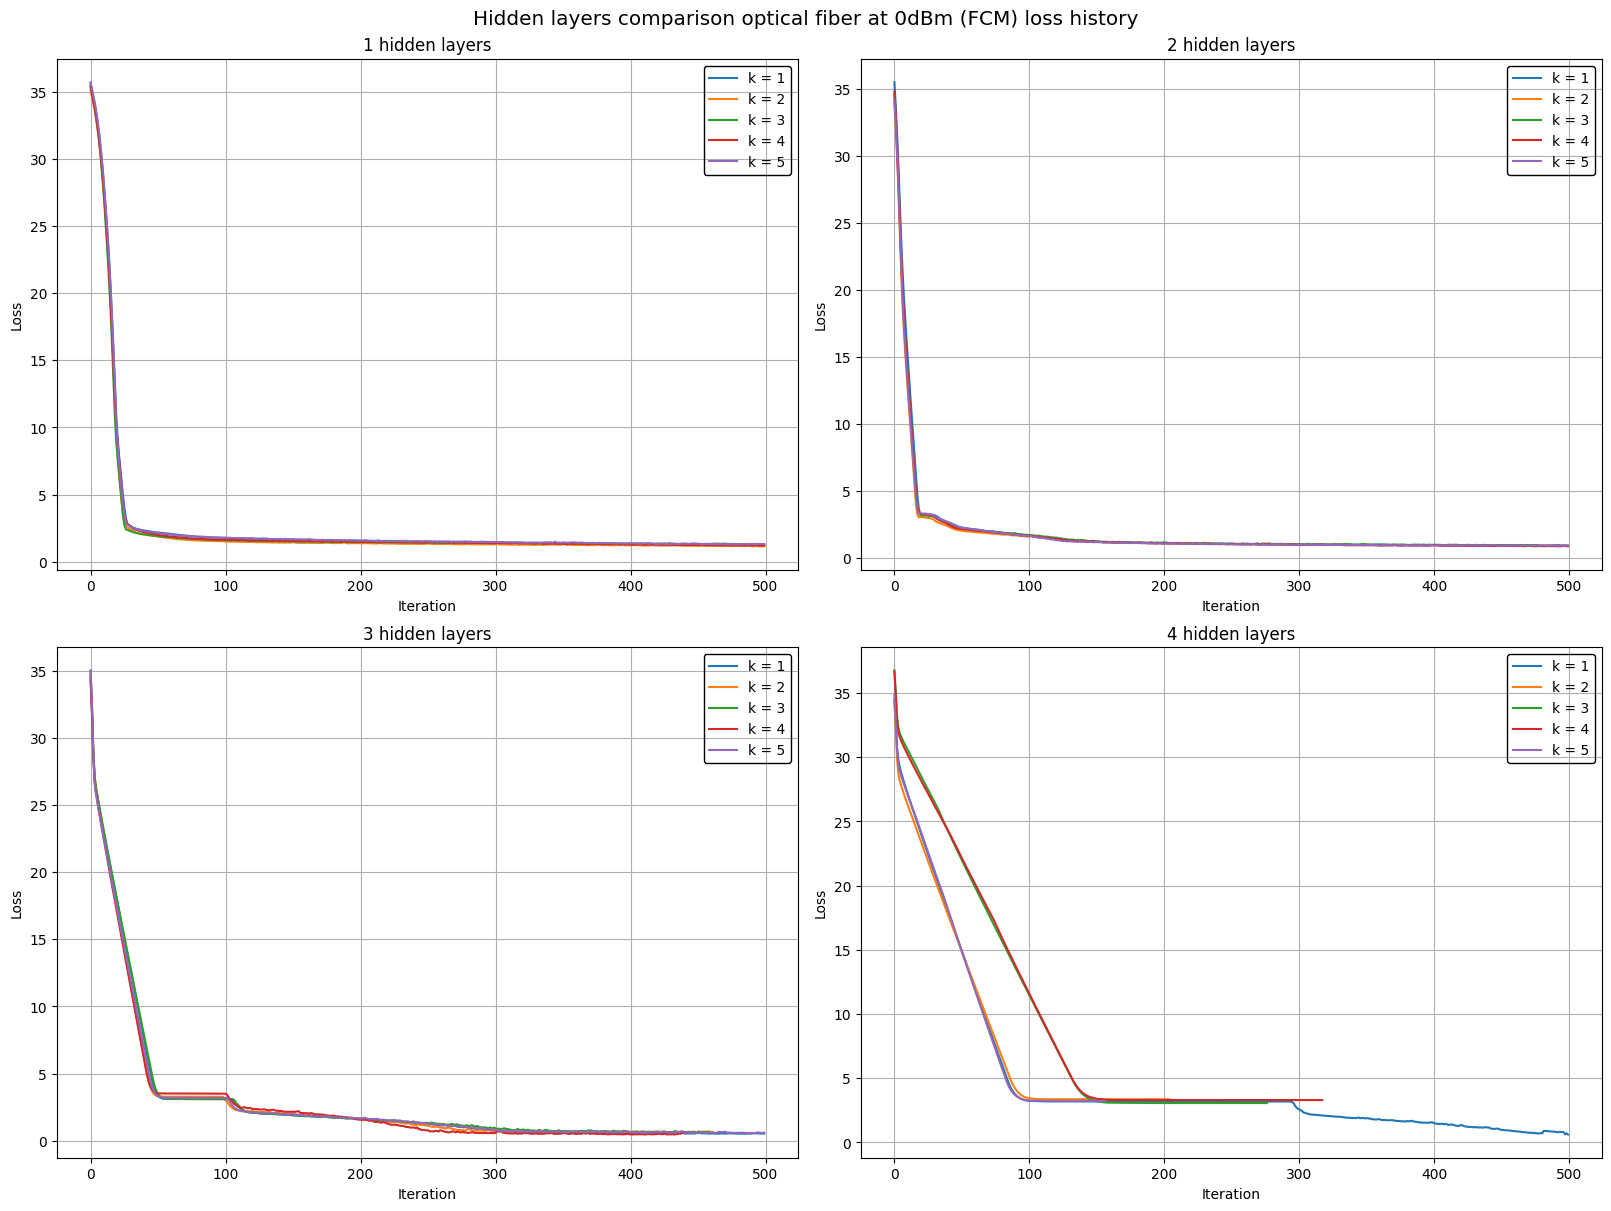

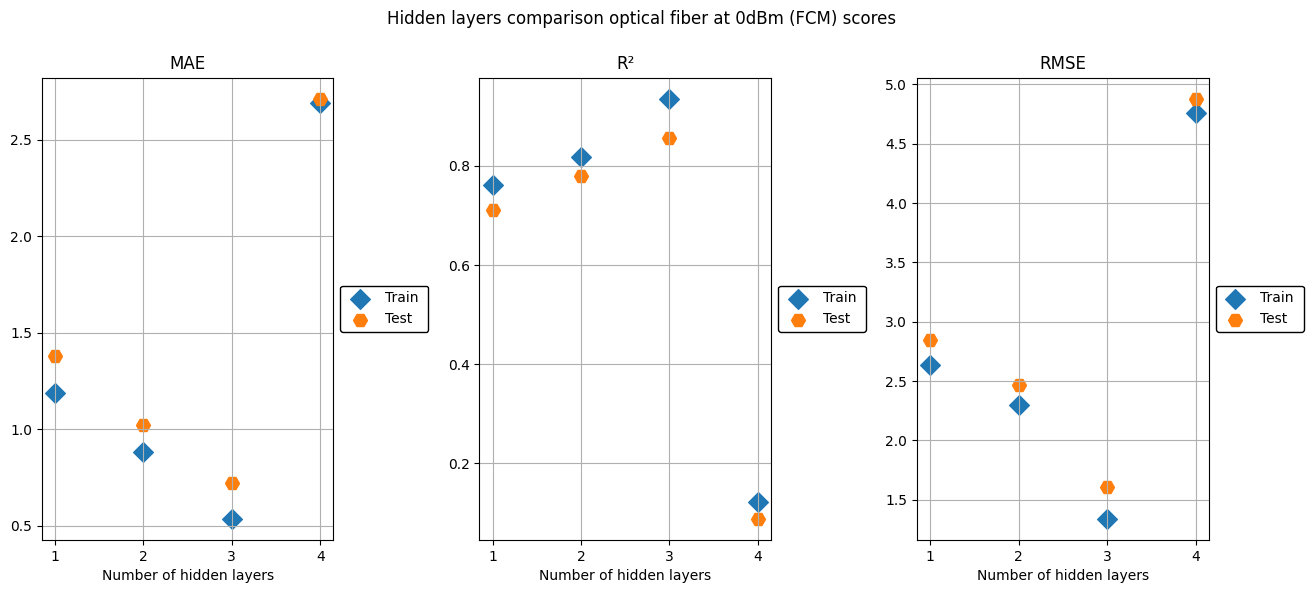

In [47]:
scores = [scores_FCM_fiber0_1HL, scores_FCM_fiber0_2HL, scores_FCM_fiber0_3HL, scores_FCM_fiber0_4HL]
plot_layers_scores(scores, "Hidden layers comparison optical fiber at 0dBm (FCM)")

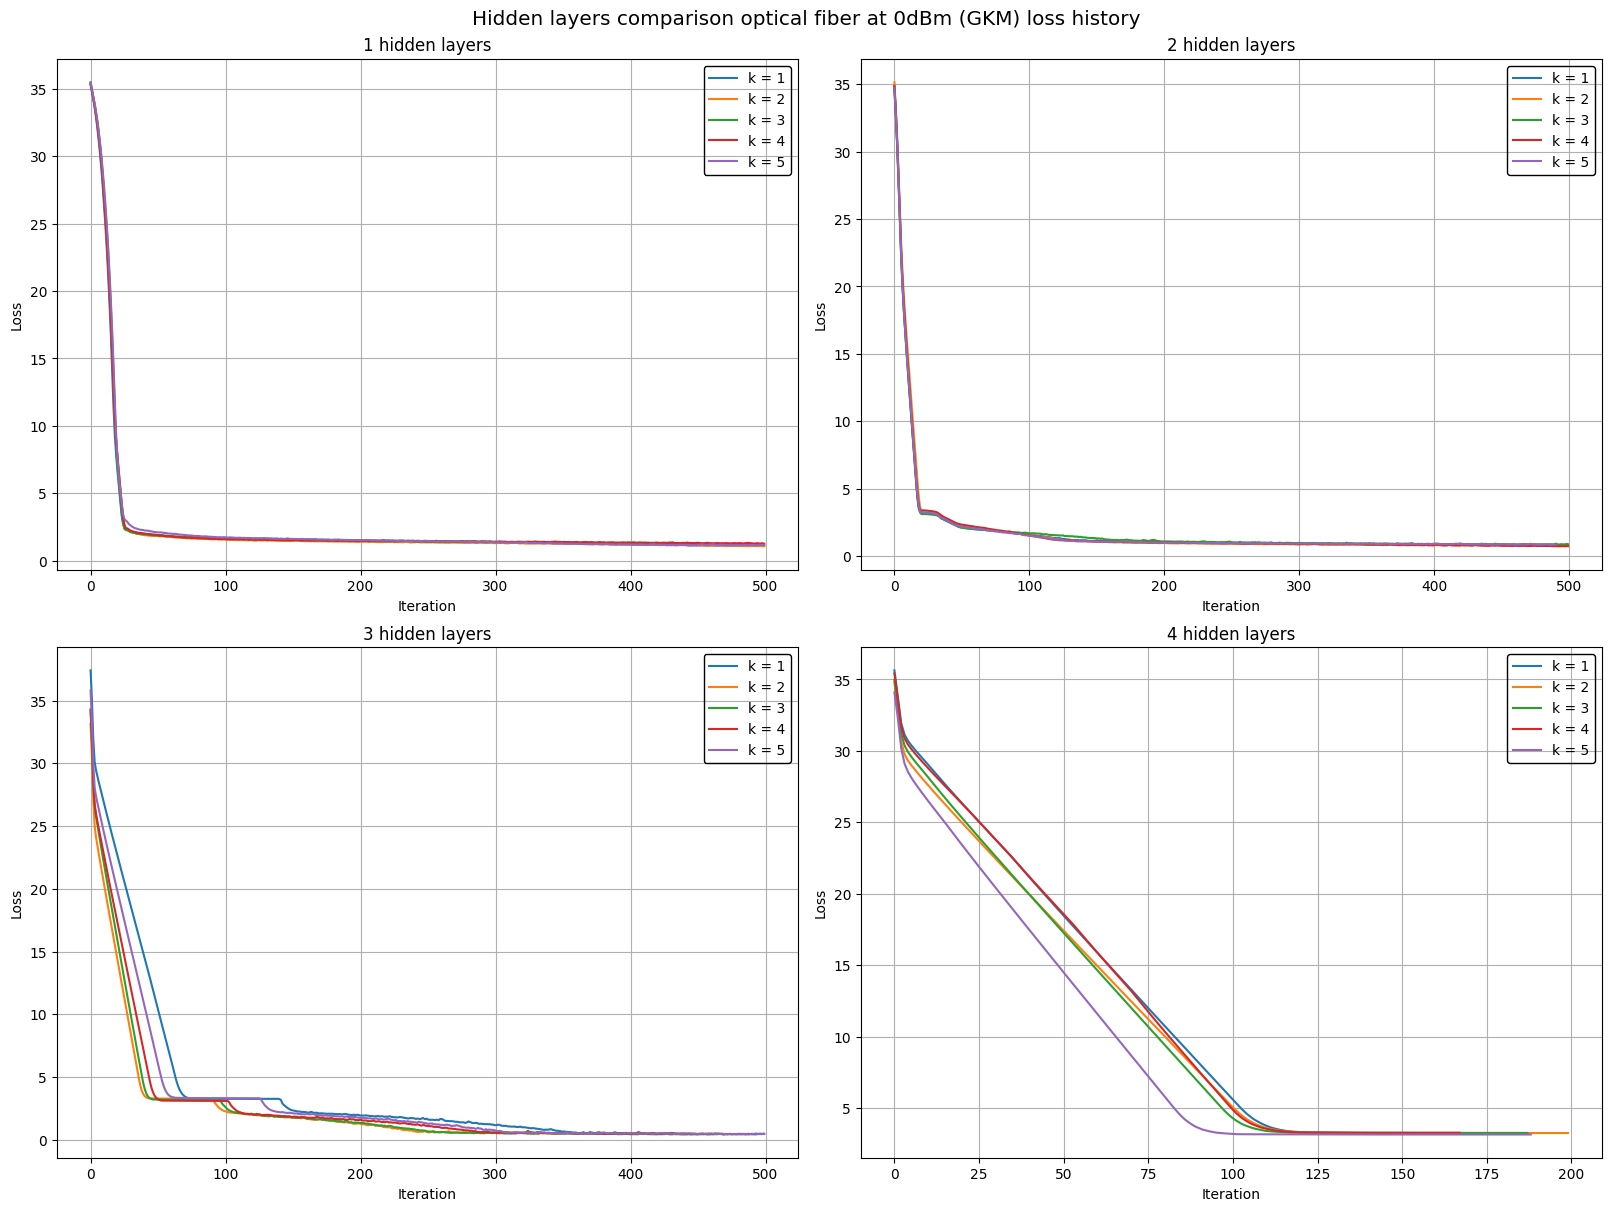

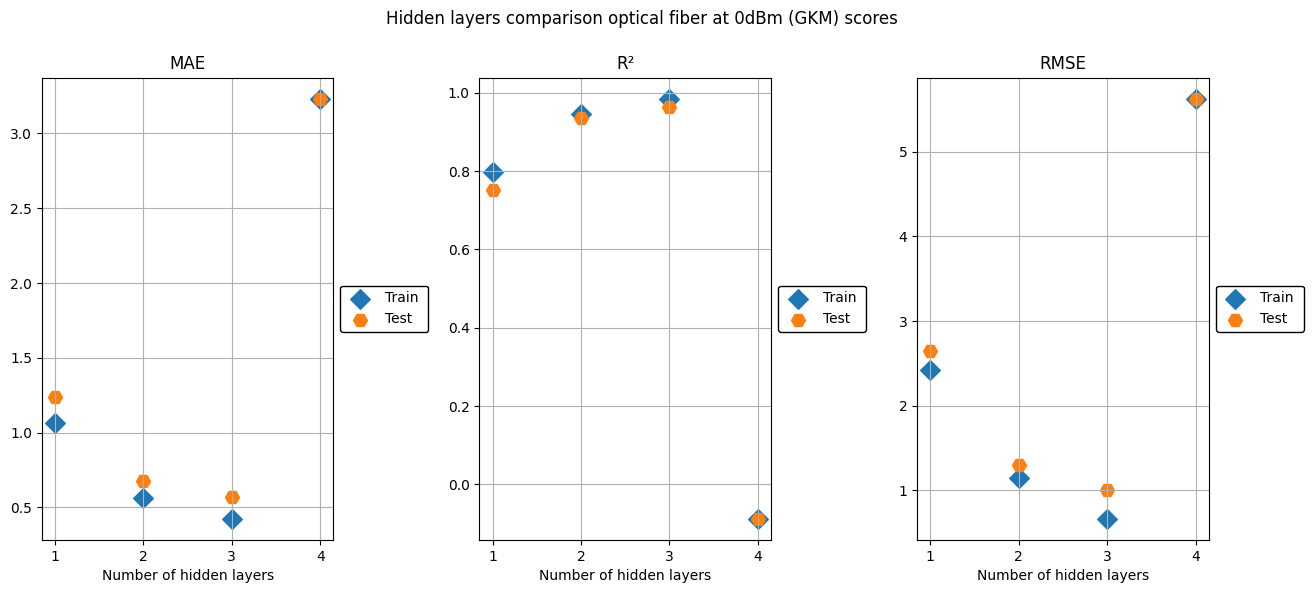

In [48]:
scores = [scores_GKM_fiber0_1HL, scores_GKM_fiber0_2HL, scores_GKM_fiber0_3HL, scores_GKM_fiber0_4HL]
plot_layers_scores(scores, "Hidden layers comparison optical fiber at 0dBm (GKM)")

### Fibra óptica a 9dBm

In [93]:
args = {"data": df_FCM_fiber9, "n_splits": 5, "max_neurons": 512, "activations": ["relu"], "use_osnr": False}
scores_FCM_fiber9_1HL_woOSNR = calc_once("scores_FCM_fiber9_1HL_woOSNR", test_estimation_model, args)

In [94]:
args = {"data": df_GKM_fiber9, "n_splits": 5, "max_neurons": 512, "activations": ["relu"], "use_osnr": False}
scores_GKM_fiber9_1HL_woOSNR = calc_once("scores_GKM_fiber9_1HL_woOSNR", test_estimation_model, args)

[{'units': 512, 'activation': 'relu'}]
Needed iterations: 142
6/6 [==============================] - 0s 689us/step
Needed iterations: 165
6/6 [==============================] - 0s 737us/step
Needed iterations: 170
6/6 [==============================] - 0s 710us/step
Needed iterations: 228
6/6 [==============================] - 0s 771us/step
Needed iterations: 156
6/6 [==============================] - 0s 849us/step
Time elapsed: 0.15 minutes


In [95]:
args = {"data": df_FCM_fiber9, "n_splits": 5, "max_neurons": 512, "activations": ["relu", "sigmoid"], "use_osnr": False}
scores_FCM_fiber9_2HL_woOSNR = calc_once("scores_FCM_fiber9_2HL_woOSNR", test_estimation_model, args)

In [96]:
args = {"data": df_GKM_fiber9, "n_splits": 5, "max_neurons": 512, "activations": ["relu", "sigmoid"], "use_osnr": False}
scores_GKM_fiber9_2HL_woOSNR = calc_once("scores_GKM_fiber9_2HL_woOSNR", test_estimation_model, args)

[{'units': 512, 'activation': 'relu'}, {'units': 256, 'activation': 'sigmoid'}]
Needed iterations: 236
6/6 [==============================] - 0s 876us/step
Needed iterations: 306
6/6 [==============================] - 0s 746us/step
Needed iterations: 286
6/6 [==============================] - 0s 911us/step
Needed iterations: 248
6/6 [==============================] - 0s 1ms/step
Needed iterations: 314
6/6 [==============================] - 0s 775us/step
Time elapsed: 0.44 minutes


In [97]:
args = {"data": df_FCM_fiber9, "n_splits": 5, "max_neurons": 512, "activations": ["relu", "tanh", "sigmoid"], "use_osnr": False}
scores_FCM_fiber9_3HL_woOSNR = calc_once("scores_FCM_fiber9_3HL_woOSNR", test_estimation_model, args)

In [98]:
args = {"data": df_GKM_fiber9, "n_splits": 5, "max_neurons": 512, "activations": ["relu", "tanh", "sigmoid"], "use_osnr": False}
scores_GKM_fiber9_3HL_woOSNR = calc_once("scores_GKM_fiber9_3HL_woOSNR", test_estimation_model, args)

[{'units': 512, 'activation': 'relu'}, {'units': 256, 'activation': 'tanh'}, {'units': 128, 'activation': 'sigmoid'}]
Needed iterations: 184
6/6 [==============================] - 0s 957us/step
Needed iterations: 521
6/6 [==============================] - 0s 946us/step
Needed iterations: 591
6/6 [==============================] - 0s 878us/step
Needed iterations: 457
6/6 [==============================] - 0s 893us/step
Needed iterations: 508
6/6 [==============================] - 0s 827us/step
Time elapsed: 0.79 minutes


In [99]:
args = {"data": df_FCM_fiber9, "n_splits": 5, "max_neurons": 512, "activations": ["relu", "relu", "tanh", "sigmoid"], "use_osnr": False}
scores_FCM_fiber9_4HL_woOSNR = calc_once("scores_FCM_fiber9_4HL_woOSNR", test_estimation_model, args)

In [100]:
args = {"data": df_GKM_fiber9, "n_splits": 5, "max_neurons": 512, "activations": ["relu", "relu", "tanh", "sigmoid"], "use_osnr": False}
scores_GKM_fiber9_4HL_woOSNR = calc_once("scores_GKM_fiber9_4HL_woOSNR", test_estimation_model, args)

[{'units': 512, 'activation': 'relu'}, {'units': 256, 'activation': 'relu'}, {'units': 128, 'activation': 'tanh'}, {'units': 64, 'activation': 'sigmoid'}]
Needed iterations: 157
6/6 [==============================] - 0s 1ms/step
Needed iterations: 121
6/6 [==============================] - 0s 914us/step
Needed iterations: 139
6/6 [==============================] - 0s 1ms/step
Needed iterations: 122
6/6 [==============================] - 0s 1ms/step
Needed iterations: 178
6/6 [==============================] - 0s 908us/step
Time elapsed: 0.31 minutes


In [101]:
%store scores_FCM_fiber9_1HL_woOSNR
%store scores_FCM_fiber9_2HL_woOSNR
%store scores_FCM_fiber9_3HL_woOSNR
%store scores_FCM_fiber9_4HL_woOSNR

%store scores_GKM_fiber9_1HL_woOSNR
%store scores_GKM_fiber9_2HL_woOSNR
%store scores_GKM_fiber9_3HL_woOSNR
%store scores_GKM_fiber9_4HL_woOSNR

Stored 'scores_FCM_fiber9_1HL_woOSNR' (dict)
Stored 'scores_FCM_fiber9_2HL_woOSNR' (dict)
Stored 'scores_FCM_fiber9_3HL_woOSNR' (dict)
Stored 'scores_FCM_fiber9_4HL_woOSNR' (dict)
Stored 'scores_GKM_fiber9_1HL_woOSNR' (dict)
Stored 'scores_GKM_fiber9_2HL_woOSNR' (dict)
Stored 'scores_GKM_fiber9_3HL_woOSNR' (dict)
Stored 'scores_GKM_fiber9_4HL_woOSNR' (dict)


In [40]:
# scores = [scores_FCM_fiber9_1HL, scores_FCM_fiber9_2HL, scores_FCM_fiber9_3HL, scores_FCM_fiber9_4HL]
# plot_layers_scores(scores, "Hidden layers comparison optical fiber at 9dBm")

## Gráfica final (Número de capas ocultas)

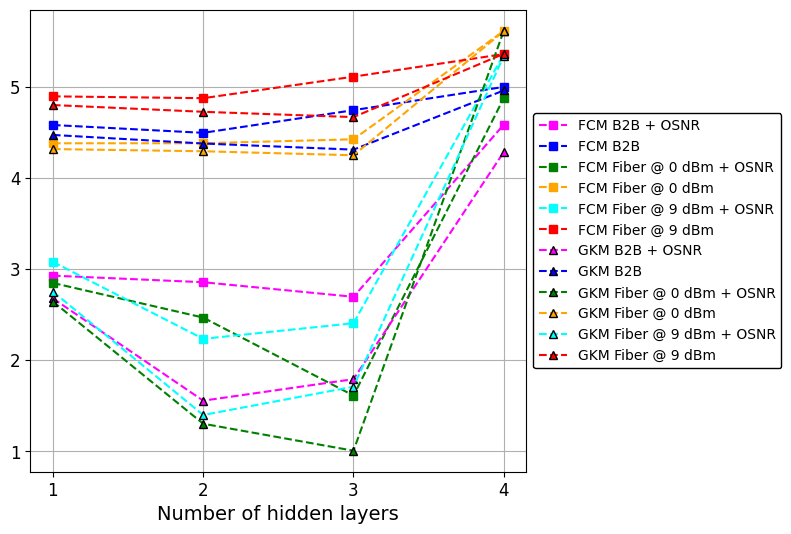

In [19]:
algorithms = ["FCM", "GKM"]
hidden_layers = [1, 2, 3, 4]
scenarios = ["B2B", "fiber0", "fiber9"]
OSNR = ["", "_woOSNR"]
layers_scores = {f"scores_{algo}_{scenario}{osnr}":
                 [np.average(
                     eval(f"scores_{algo}_{scenario}_{layers}HL{osnr}").get(
                         "rmse"
                     ).get(
                         "test"
                     )
                 ) for layers in hidden_layers]
                 for algo in algorithms
                 for scenario in scenarios
                 for osnr in OSNR}

# Markers for algorithm 
markers = {"FCM": "s", "GKM": "^"}

# Colors for scenario (blue for B2B, orange for 0dBm, red for 9dBm)
colors = {"B2B": ["blue", "magenta"], "fiber0": ["orange", "green"], "fiber9": ["red", "cyan"]}

plt.figure(figsize=(8, 6), layout="constrained")
ax = plt.subplot(1, 1, 1)
for algo in algorithms:
    for scenario in scenarios:
        for osnr in OSNR:
            scenario_label = "Fiber @ 0 dBm" if scenario == "fiber0" else "Fiber @ 9 dBm" if scenario != "B2B" else scenario
            OSNR_label = "+ OSNR" if osnr == "" else ""
            label = f"{algo} {scenario_label} {OSNR_label}"
            color = colors.get(scenario)[0 if OSNR_label == "" else 1]
            marker = markers.get(algo)
            markeredgecolor = "black" if algo == "FCM" else None
            plt.plot(hidden_layers, layers_scores.get(f"scores_{algo}_{scenario}{osnr}"),
                     color=color, marker=marker,
                     linestyle="--",
                     markeredgecolor="black" if algo == "GKM" else None,
                     label=f"{label}")
            
plt.xlabel("Number of hidden layers", fontsize=14)
ax.set_xticks(hidden_layers)
# Shrink current axis by 20%
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.tick_params(axis='both', labelsize=12)

# Transparent white box black edge legend
legend = plt.legend(loc="center left", bbox_to_anchor=(1, 0.5),
                    edgecolor="black")
legend.get_frame().set_alpha(None)
legend.get_frame().set_facecolor((1, 1, 1, 0.01))
plt.grid(True)

plt.savefig("hidden_layers_rmse.svg", format="svg", transparent=True, bbox_inches="tight")

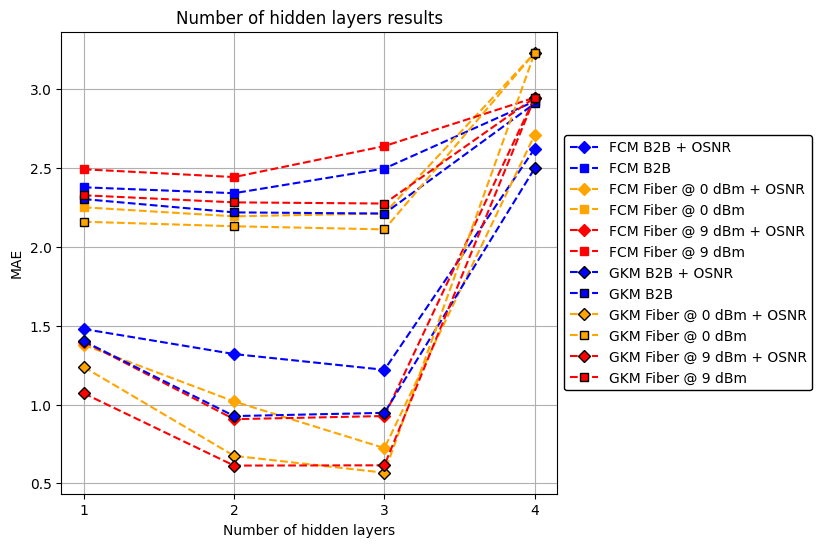

In [49]:
algorithms = ["FCM", "GKM"]
hidden_layers = [1, 2, 3, 4]
scenarios = ["B2B", "fiber0", "fiber9"]
OSNR = ["", "_woOSNR"]
layers_scores = {f"scores_{algo}_{scenario}{osnr}":
                 [np.average(
                     eval(f"scores_{algo}_{scenario}_{layers}HL{osnr}").get(
                         "mae"
                     ).get(
                         "test"
                     )
                 ) for layers in hidden_layers]
                 for algo in algorithms
                 for scenario in scenarios
                 for osnr in OSNR}

# Markers for OSNR inclusion
markers = {"": "D", "_woOSNR": "s"}

# Colors for scenario
colors = {"B2B": "blue", "fiber0": "orange", "fiber9": "red"}

plt.figure(figsize=(8, 6), layout="constrained")
ax = plt.subplot(1, 1, 1)
for algo in algorithms:
    for scenario in scenarios:
        for osnr in OSNR:
            scenario_label = "Fiber @ 0 dBm" if scenario == "fiber0" else "Fiber @ 9 dBm" if scenario != "B2B" else scenario
            OSNR_label = "+ OSNR" if osnr == "" else ""
            label = f"{algo} {scenario_label} {OSNR_label}"
            color=colors.get(scenario)
            marker = markers.get(osnr)
            markeredgecolor = "black" if algo == "GKM" else None
            plt.plot(hidden_layers, layers_scores.get(f"scores_{algo}_{scenario}{osnr}"),
                     color=colors.get(scenario), marker=markers.get(osnr),
                     linestyle="--", markeredgecolor=markeredgecolor,
                     label=f"{label}")
            
plt.title("Number of hidden layers results")
plt.xlabel("Number of hidden layers")
ax.set_xticks(hidden_layers)
plt.ylabel("MAE")
# Shrink current axis by 20%
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

# Transparent white box black edge legend
legend = plt.legend(loc="center left", bbox_to_anchor=(1, 0.5),
                    edgecolor="black")
legend.get_frame().set_alpha(None)
legend.get_frame().set_facecolor((1, 1, 1, 0.01))
plt.grid(True)

plt.savefig("hidden_layers_rmse.svg", format="svg", transparent=True, bbox_inches="tight")

## Comparación variando la función de pérdida (MAE vs. RMSE)

In [119]:
args = {"data": df_FCM_B2B, "n_splits": 5, "max_neurons": 256, "activations": ["relu", "tanh", "sigmoid"], "loss_fn": "mean_absolute_error"}
scores_FCM_MAE_B2B = calc_once("scores_FCM_MAE_B2B", test_estimation_model, args)

In [120]:
args = {"data": df_FCM_B2B, "n_splits": 5, "max_neurons": 256, "activations": ["relu", "tanh", "sigmoid"], "loss_fn": "mean_squared_error"}
scores_FCM_MSE_B2B = calc_once("scores_FCM_MSE_B2B", test_estimation_model, args)

In [121]:
args = {"data": df_FCM_fiber0, "n_splits": 5, "max_neurons": 256, "activations": ["relu", "tanh", "sigmoid"], "loss_fn": "mean_absolute_error"}
scores_FCM_MAE_fiber0 = calc_once("scores_FCM_MAE_fiber0", test_estimation_model, args)

In [122]:
args = {"data": df_FCM_fiber0, "n_splits": 5, "max_neurons": 256, "activations": ["relu", "tanh", "sigmoid"], "loss_fn": "mean_squared_error"}
scores_FCM_MSE_fiber0 = calc_once("scores_FCM_MSE_fiber0", test_estimation_model, args)

In [123]:
args = {"data": df_FCM_fiber9, "n_splits": 5, "max_neurons": 256, "activations": ["relu", "tanh", "sigmoid"], "loss_fn": "mean_absolute_error"}
scores_FCM_MAE_fiber9 = calc_once("scores_FCM_MAE_fiber9", test_estimation_model, args)

In [124]:
args = {"data": df_FCM_fiber9, "n_splits": 5, "max_neurons": 256, "activations": ["relu", "tanh", "sigmoid"], "loss_fn": "mean_squared_error"}
scores_FCM_MSE_fiber9 = calc_once("scores_FCM_MSE_fiber9", test_estimation_model, args)

In [125]:
%store scores_FCM_MAE_B2B
%store scores_FCM_MSE_B2B
%store scores_FCM_MAE_fiber0
%store scores_FCM_MSE_fiber0
%store scores_FCM_MAE_fiber9
%store scores_FCM_MSE_fiber9

Stored 'scores_FCM_MAE_B2B' (dict)
Stored 'scores_FCM_MSE_B2B' (dict)
Stored 'scores_FCM_MAE_fiber0' (dict)
Stored 'scores_FCM_MSE_fiber0' (dict)
Stored 'scores_FCM_MAE_fiber9' (dict)
Stored 'scores_FCM_MSE_fiber9' (dict)


### Gráficas

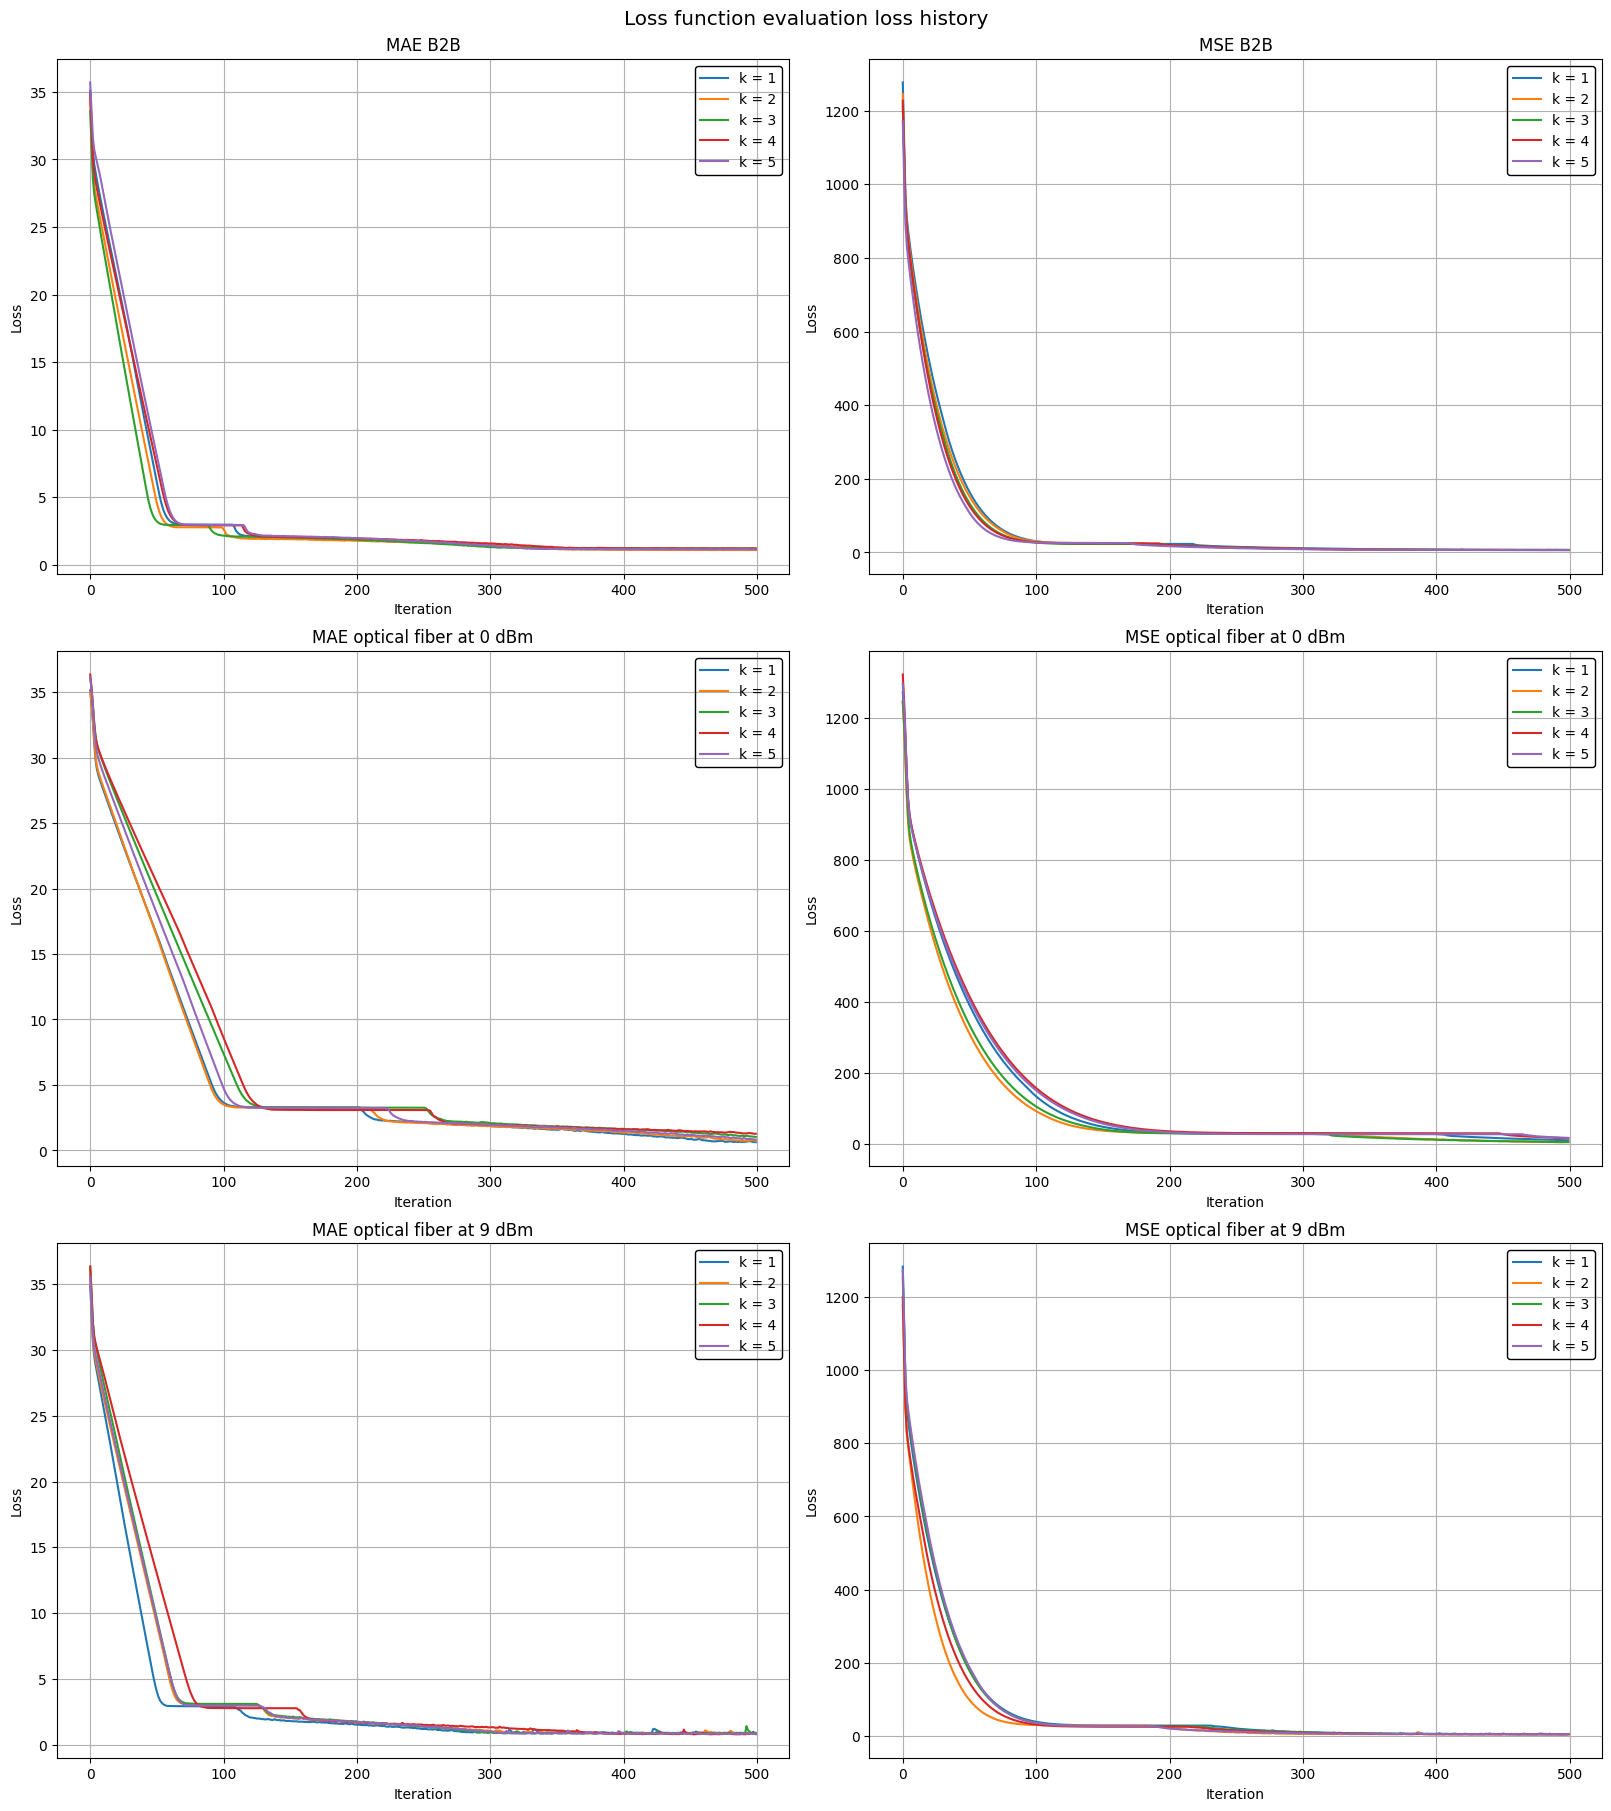

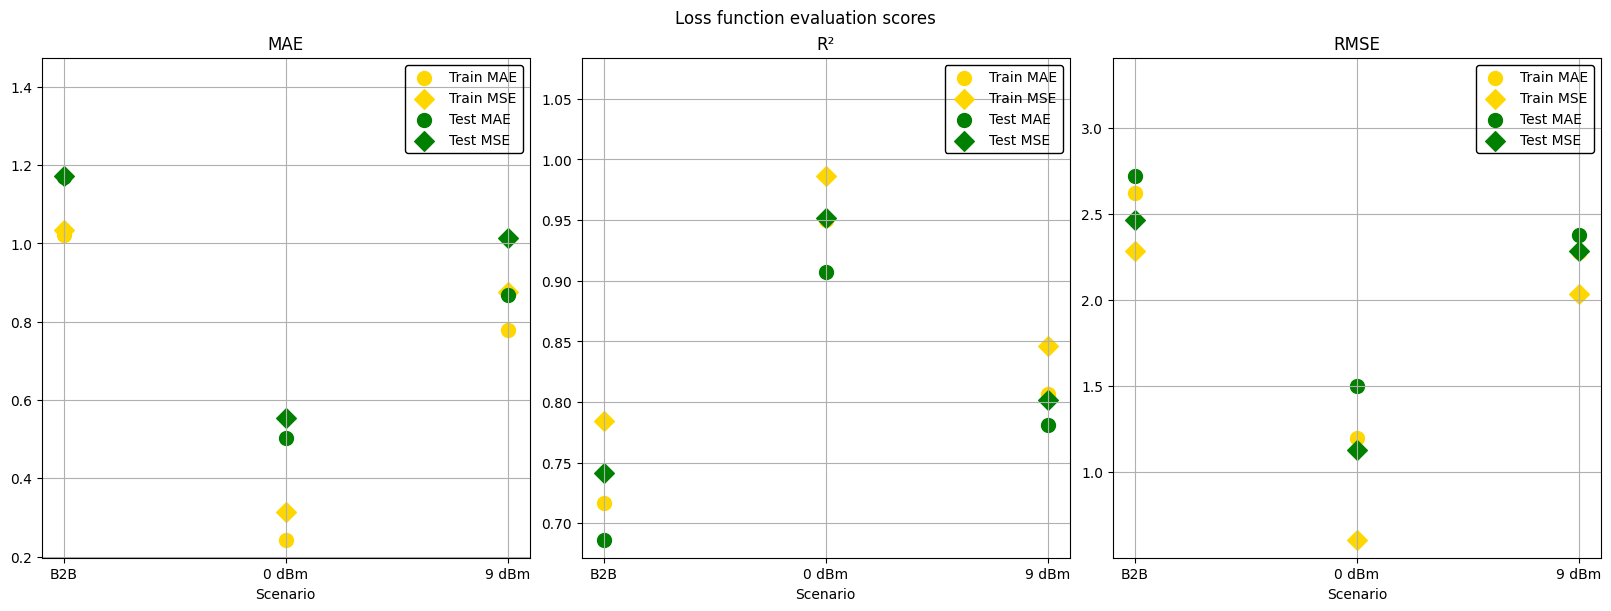

In [130]:
scores = [scores_FCM_MAE_B2B, scores_FCM_MSE_B2B, scores_FCM_MAE_fiber0, scores_FCM_MSE_fiber0, scores_FCM_MAE_fiber9, scores_FCM_MSE_fiber9]
plot_loss_scores(scores, "Loss function evaluation")